# Clustering
This notebook demonstrates clustering techniques applied to venture capital (VC) and incubators interactions data. It includes data preprocessing, feature engineering, and clustering using various algorithms.

In [2]:
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
import umap
from tqdm import tqdm
from kmodes.kprototypes import KPrototypes
from kmodes.kmodes import KModes
from sklearn.cluster import KMeans
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
import shap
import seaborn as sns


## Read and Clear Data
Load the datasets for companies, funding rounds, investments, and investors. Perform initial filtering and cleaning to prepare the data for analysis.

In [3]:
folder_dir = 'France_Data'

companies = pd.read_csv(f'{folder_dir}/companies.csv', encoding="utf-8")
fundings_rounds = pd.read_csv(f'{folder_dir}/funding_rounds.csv', encoding="utf-8")
investments = pd.read_csv(f'{folder_dir}/investments.csv', encoding="utf-8")
investors = pd.read_csv(f'{folder_dir}/investors.csv', encoding="utf-8")

In [4]:
incubated_investments = investments[investments['investor_types'].str.contains('accelerator|incubator', case=False, na=False)]
vc_investments = investments[investments['investor_types'].str.contains('venture', case=False, na=False) & 
                 ~investments['investor_types'].str.contains('accelerator|incubator', case=False, na=False)]

In [5]:
two_stage_investments = pd.merge(
    incubated_investments[['uuid', 'investor_uuid', 'investor_name', 'investor_types', 'org_uuid']], 
    vc_investments[['uuid', 'investor_uuid', 'investor_name', 'investor_types', 'org_uuid', 'company_name', 'category_groups_list', 'investment_type', 'total_funding_usd']], 
    on='org_uuid', 
    how='inner'
).groupby('org_uuid')

print("Type:", type(two_stage_investments))
# print("Shape:",two_stage_investments.shape)
# print("Columns:",two_stage_investments.columns)

two_stage_investments.head()

Type: <class 'pandas.core.groupby.generic.DataFrameGroupBy'>


,uuid_x,investor_uuid_x,investor_name_x,investor_types_x,org_uuid,uuid_y,investor_uuid_y,investor_name_y,investor_types_y,company_name,category_groups_list,investment_type,total_funding_usd
0,d374ef44-854c-d1ec-29f2-1fa463bf11fd,447ffffd-840f-89f9-e734-2e096d3c2c96,Phitrust Partenaires,incubator,bd6c667a-3512-8b7f-c1e2-3a39468051ad,8943ba87-ee0e-0b0b-b145-09e67dc93dca,51ec858f-94df-88ca-5e47-a679f464f708,Alitis,venture capital,Dolead,"Advertising,Internet Services,Media and Entert...",series_a,20593286.0
1,d374ef44-854c-d1ec-29f2-1fa463bf11fd,447ffffd-840f-89f9-e734-2e096d3c2c96,Phitrust Partenaires,incubator,bd6c667a-3512-8b7f-c1e2-3a39468051ad,2580ec51-e8fb-a64b-f1a5-40e39710bba7,7fb70fb0-de1d-3f2a-45b1-437296dbe161,Adverline,corporate venture capital,Dolead,"Advertising,Internet Services,Media and Entert...",series_a,20593286.0
2,d374ef44-854c-d1ec-29f2-1fa463bf11fd,447ffffd-840f-89f9-e734-2e096d3c2c96,Phitrust Partenaires,incubator,bd6c667a-3512-8b7f-c1e2-3a39468051ad,e8f16ca7-8165-a6f0-0a01-98170b90e50a,51ec858f-94df-88ca-5e47-a679f464f708,Alitis,venture capital,Dolead,"Advertising,Internet Services,Media and Entert...",pre_seed,20593286.0
3,d374ef44-854c-d1ec-29f2-1fa463bf11fd,447ffffd-840f-89f9-e734-2e096d3c2c96,Phitrust Partenaires,incubator,bd6c667a-3512-8b7f-c1e2-3a39468051ad,49cf2542-3111-27e7-8502-352c4e3664aa,7fb70fb0-de1d-3f2a-45b1-437296dbe161,Adverline,corporate venture capital,Dolead,"Advertising,Internet Services,Media and Entert...",pre_seed,20593286.0
4,d374ef44-854c-d1ec-29f2-1fa463bf11fd,447ffffd-840f-89f9-e734-2e096d3c2c96,Phitrust Partenaires,incubator,bd6c667a-3512-8b7f-c1e2-3a39468051ad,5a11e0ce-2b86-14aa-03de-66eb496b9fc5,2c91f1dc-0aa5-09d9-d66f-64e1f7178a2e,XAnge,"micro vc,venture capital",Dolead,"Advertising,Internet Services,Media and Entert...",series_b,20593286.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5215,445b1407-36e2-4f01-a730-f803699dfc60,a3a57aba-79be-4ae0-8925-4049a7831318,Digital Africa,accelerator,5ccdc536-d523-4a4d-9641-e8c57cab3b8b,a6fc07a8-2628-42bf-ab1b-aa1df9817897,304cc556-ebea-358a-70c6-b411c99ea516,UGFS,"private equity firm,venture capital",Cynoia,"Information Technology,Internet Services,Messa...",seed,1612091.0
5216,445b1407-36e2-4f01-a730-f803699dfc60,a3a57aba-79be-4ae0-8925-4049a7831318,Digital Africa,accelerator,5ccdc536-d523-4a4d-9641-e8c57cab3b8b,7d607c0d-fe3c-46af-b427-77d07578b031,662d910a-103e-44d6-89a7-bf35bffd9ca8,216 Capital,venture capital,Cynoia,"Information Technology,Internet Services,Messa...",seed,1612091.0
5217,445b1407-36e2-4f01-a730-f803699dfc60,a3a57aba-79be-4ae0-8925-4049a7831318,Digital Africa,accelerator,5ccdc536-d523-4a4d-9641-e8c57cab3b8b,140865f7-e849-49e6-a403-6f7dbd0a814f,304cc556-ebea-358a-70c6-b411c99ea516,UGFS,"private equity firm,venture capital",Cynoia,"Information Technology,Internet Services,Messa...",seed,1612091.0
5218,445b1407-36e2-4f01-a730-f803699dfc60,a3a57aba-79be-4ae0-8925-4049a7831318,Digital Africa,accelerator,5ccdc536-d523-4a4d-9641-e8c57cab3b8b,7a7b4bc1-57c4-4cb7-9a36-b1c32721285e,662d910a-103e-44d6-89a7-bf35bffd9ca8,216 Capital,venture capital,Cynoia,"Information Technology,Internet Services,Messa...",undisclosed,1612091.0


In [6]:
df_two_stage_investments = two_stage_investments.apply(lambda x: x, include_groups=False)

print("Shape:", df_two_stage_investments.shape)
df_two_stage_investments.head()

Shape: (5244, 12)


uuid_x  \
org_uuid                                                                          
001def67-5ccd-4f04-93ad-252b12c4f460 1548  e45a7ceb-7608-480e-94e3-e7b34253e9e0   
                                     1549  e45a7ceb-7608-480e-94e3-e7b34253e9e0   
                                     1550  e45a7ceb-7608-480e-94e3-e7b34253e9e0   
008a2ebe-af44-4e39-84ae-506550877b8f 3657  a535ff53-079b-4f2b-8e3a-d9fd864278cc   
009cfee9-0a1c-4e25-8e70-49398e7daa64 4250  a04dec6a-ea4b-4404-94a5-e1206b0d9af3   

                                                                investor_uuid_x  \
org_uuid                                                                          
001def67-5ccd-4f04-93ad-252b12c4f460 1548  2db426c2-f297-da4e-fec8-62fd4b7b35c2   
                                     1549  2db426c2-f297-da4e-fec8-62fd4b7b35c2   
                                     1550  2db426c2-f297-da4e-fec8-62fd4b7b35c2   
008a2ebe-af44-4e39-84ae-506550877b8f 3657  8cbd9845-c791-b45e-047e-c6385a72dc05   
009cfee9-0a1c-4e25-8e70-49398e7daa64 4250  23e28429-d164-3882-243e-ab22a40360c1   

                                          investor_name_x  \
org_uuid                                                    
001def67-5ccd-4f04-93ad-252b12c4f460 1548      The Family   
                                     1549      The Family   
                                     1550      The Family   
008a2ebe-af44-4e39-84ae-506550877b8f 3657           WILCO   
009cfee9-0a1c-4e25-8e70-49398e7daa64 4250      Impact USA   

                                                                      investor_types_x  \
org_uuid                                                                                 
001def67-5ccd-4f04-93ad-252b12c4f460 1548  accelerator,angel group,incubator,syndicate   
                                     1549  accelerator,angel group,incubator,syndicate   
                                     1550  accelerator,angel group,incubator,syndicate   
008a2ebe-af44-4e39-84ae-506550877b8f 3657                                  accelerator   
009cfee9-0a1c-4e25-8e70-49398e7daa64 4250                                  accelerator   

                                                                         uuid_y  \
org_uuid                                                                          
001def67-5ccd-4f04-93ad-252b12c4f460 1548  db4fd925-0056-4625-ac93-2d04e4f17fab   
                                     1549  ccbe1ef1-b02b-4ee9-97bc-83a7b48b2cb1   
                                     1550  1c6713c5-096e-4b83-8619-6445b0496690   
008a2ebe-af44-4e39-84ae-506550877b8f 3657  6db25d95-6cf4-4cc2-b1b6-ff28d93c26b2   
009cfee9-0a1c-4e25-8e70-49398e7daa64 4250  827b213d-45a5-4b94-a6ce-372ed826707a   

                                                                investor_uuid_y  \
org_uuid                                                                          
001def67-5ccd-4f04-93ad-252b12c4f460 1548  b08efc27-da40-505a-6f9d-c9e14247bf36   
                                     1549  94e4f649-4cc6-8aa3-5e8a-771e50cd9a7f   
                                     1550  e8de4e94-b48c-76f6-3770-aac7e51158f4   
008a2ebe-af44-4e39-84ae-506550877b8f 3657  93c87ab7-7cee-5c54-9941-104693dbbdba   
009cfee9-0a1c-4e25-8e70-49398e7daa64 4250  0c5d60dc-ffff-4fef-8aa2-5f8e8420ef53   

                                            investor_name_y  \
org_uuid                                                      
001def67-5ccd-4f04-93ad-252b12c4f460 1548             Accel   
                                     1549        Slack Fund   
                                     1550        Point Nine   
008a2ebe-af44-4e39-84ae-506550877b8f 3657     Plug and Play   
009cfee9-0a1c-4e25-8e70-49398e7daa64 4250  Supernova Invest   

                                                                            investor_types_y  \
org_uuid                                                                                       
001def67-5ccd-4f04-93ad-252b12c4f460 1548           

In [7]:
investor_pairs = two_stage_investments.apply(lambda x: [(x['investor_uuid_x'].iloc[i], x['investor_uuid_y'].iloc[i]) for i in range(len(x))], include_groups=False).explode().values

vc_investors = df_two_stage_investments[['investor_uuid_y']].rename(columns={'investor_uuid_y': 'investor_uuid'}).drop_duplicates().reset_index(drop=True)

print("Shape:", vc_investors.shape)
vc_investors.head()

Shape: (1114, 1)


,investor_uuid
0,b08efc27-da40-505a-6f9d-c9e14247bf36
1,94e4f649-4cc6-8aa3-5e8a-771e50cd9a7f
2,e8de4e94-b48c-76f6-3770-aac7e51158f4
3,93c87ab7-7cee-5c54-9941-104693dbbdba
4,0c5d60dc-ffff-4fef-8aa2-5f8e8420ef53


## Calculate VCs' Selectivity Gini
Define a Gini coefficient function to measure the selectivity of venture capitalists based on their investment patterns.

In [8]:
def gini(x):
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    
    return diffsum / (len(x)**2 * np.mean(x))

In [9]:
vc_investors_w_gini = vc_investors.copy()
selectivity_ginis = []

for vc_uuid in vc_investors_w_gini['investor_uuid']:
    vc_pairs = [pair for pair in investor_pairs if vc_uuid in pair]
    vc_interactions_counter = np.array([vc_pairs.count(pair) for pair in vc_pairs])
    vc_gini = gini(vc_interactions_counter)
    selectivity_ginis.append(vc_gini)

vc_investors_w_gini['selectivity_gini'] = selectivity_ginis
vc_investors_w_gini.head()

,investor_uuid,selectivity_gini
0,b08efc27-da40-505a-6f9d-c9e14247bf36,0.137827
1,94e4f649-4cc6-8aa3-5e8a-771e50cd9a7f,0.000000
2,e8de4e94-b48c-76f6-3770-aac7e51158f4,0.150000
3,93c87ab7-7cee-5c54-9941-104693dbbdba,0.355556
4,0c5d60dc-ffff-4fef-8aa2-5f8e8420ef53,0.347767


In [10]:
investors.head()

,uuid,name,city,region,country_code,investor_types,investment_count,founded_year,short_description,num_exits,logo_url,country
0,df662812-7f97-0b43-9d3e-12f64f504fbb,Meta,Menlo Park,California,USA,NaN,58.0,2004.0,Meta is a social technology company that enabl...,NaN,https://images.crunchbase.com/image/upload/t_c...,United States
1,b08efc27-da40-505a-6f9d-c9e14247bf36,Accel,Palo Alto,California,USA,venture capital,2140.0,1983.0,Accel is an seed and growth-stage venture capi...,390.0,https://images.crunchbase.com/image/upload/t_c...,United States
2,8d5c7e48-82da-3025-dd46-346a31bab86f,Meritech Capital Partners,Palo Alto,California,USA,venture capital,330.0,1999.0,Meritech Capital provides late-stage venture c...,130.0,https://images.crunchbase.com/image/upload/t_c...,United States
3,960eb982-a434-7554-0ca4-ac71108fd7c1,Austin Ventures,Austin,Texas,USA,venture capital,392.0,1984.0,Austin Ventures specializes in partnering with...,120.0,https://images.crunchbase.com/image/upload/t_c...,United States
4,d29973c3-95ec-691d-defd-6a6ba713c72a,Redpoint,Menlo Park,California,USA,venture capital,779.0,1999.0,Redpoint partners with visionary founders to c...,169.0,https://images.crunchbase.com/image/upload/t_c...,United States


In [11]:
merged_gini = vc_investors_w_gini.merge(investors[['uuid', 'name']], left_on='investor_uuid', right_on='uuid').sort_values('selectivity_gini', ascending=False)
merged_gini

,investor_uuid,selectivity_gini,uuid,name
96,ae6eb8da-ebb3-42be-9ee6-644a57af8755,0.481098,ae6eb8da-ebb3-42be-9ee6-644a57af8755,European Innovation Council
17,0cab37ac-f2b5-4581-fa24-169ef0a8ffa8,0.424260,0cab37ac-f2b5-4581-fa24-169ef0a8ffa8,Elaia
209,da761bfc-adb7-e9b1-b90d-52d436c96e75,0.410514,da761bfc-adb7-e9b1-b90d-52d436c96e75,Entrepreneur First
133,22698b46-7e2c-a7ad-208e-f7ef5522567b,0.405160,22698b46-7e2c-a7ad-208e-f7ef5522567b,Serena
128,0be7e715-b23f-4e15-3782-72a5d7991c19,0.401392,0be7e715-b23f-4e15-3782-72a5d7991c19,Isai
...,...,...,...,...
16,3768b06d-3686-4cb4-bfa1-dc992271f92a,0.000000,3768b06d-3686-4cb4-bfa1-dc992271f92a,Relyens
18,e9549cf9-777a-450c-a789-e667359e8c7e,0.000000,e9549cf9-777a-450c-a789-e667359e8c7e,2C Invest
19,8e7af0c0-dccb-4d78-8c30-09c1eebb71a5,0.000000,8e7af0c0-dccb-4d78-8c30-09c1eebb71a5,Var Business Angels
20,a06a7597-b7dc-ede7-6524-430bdc7dc4aa,0.000000,a06a7597-b7dc-ede7-6524-430bdc7dc4aa,Inventures SA


Why is it 

In [12]:
top_20_vcs = merged_gini['name'].head(20)
favorite_incubators = {}

for vc_uuid in top_20_vcs:
    vc_data = df_two_stage_investments[df_two_stage_investments['investor_name_y'] == vc_uuid]
    incubator_counts = vc_data['investor_name_x'].value_counts()
    favorite_incubators[vc_uuid] = incubator_counts.head(5)
    
favorite_incubators = favorite_incubators

for vc, incubators in favorite_incubators.items():
    print(f"VC: {vc}")
    print(incubators)
    print()

VC: European Innovation Council
investor_name_x
AGORANOV           37
EIC Accelerator     7
WILCO               6
CARB-X              6
ACET Capital        4
Name: count, dtype: int64

VC: Elaia
investor_name_x
AGORANOV      19
WILCO         15
RebelBio       9
The Family     7
IOT Valley     5
Name: count, dtype: int64

VC: Entrepreneur First
investor_name_x
AGORANOV                         11
EIC Accelerator                   4
GROW Agrifoodtech Accelerator     2
SPACE-F                           2
WILCO                             2
Name: count, dtype: int64

VC: Serena
investor_name_x
WILCO                           16
AGORANOV                         9
EIC Accelerator                  4
The Family                       2
Global FinTech Hackcelerator     2
Name: count, dtype: int64

VC: Isai
investor_name_x
WILCO         14
SAP.iO         6
AGORANOV       5
VentureOut     3
NUMA           3
Name: count, dtype: int64

VC: Karista
investor_name_x
AGORANOV           15
WILCO          

**Comments**:

Gini 0 = VC is interactin gin the same freequence with many incubators

Gini 1 = VC is concentrating it's investments in the same incubators

In [47]:
incubator_counts = {}

for incubators in favorite_incubators.values():
  for incubator, count in incubators.items():
    if incubator in incubator_counts:
      incubator_counts[incubator] += count
    else:
      incubator_counts[incubator] = count

# Convert to a sorted list of tuples (incubator, accumulated count)
sorted_incubator_counts = pd.DataFrame(sorted(incubator_counts.items(), key=lambda x: x[1], reverse=True), columns=['Incubator', 'Accumulated Count'])

sorted_incubator_counts

,Incubator,Accumulated Count
0,AGORANOV,184
1,WILCO,139
2,HAX,82
3,Crédit Agricole,33
4,RebelBio,29
5,EIC Accelerator,26
6,The Family,25
7,Via ID,24
8,SAP.iO,21
9,Eurasante,21


In [ ]:
top_20_vcs = sorted_incubator_counts['Incubator'].head(20)
favorite_vcs = {}

for incubator_name in sorted_incubator_counts:
    incubator_data = df_two_stage_investments[df_two_stage_investments['investor_name_x'] == incubator_name]
    vcs_counts = incubator_data['investor_name_y'].value_counts()
    favorite_vcs[incubator_name] = vcs_counts.head(5)
    
favorite_vcs = favorite_vcs

for incubator, incubators in favorite_vcs.items():
    print(f"Incubator: {incubator}")
    print(incubators)
    print()

Incubator: Incubator
Series([], Name: count, dtype: int64)

Incubator: Accumulated Count
Series([], Name: count, dtype: int64)



## One-Hot Encode VCs' Categories
Extract and encode unique categories from the dataset to analyze the focus areas of venture capitalists.

In [14]:
# Get all unique values in 'category_groups_list' column
unique_categories = df_two_stage_investments['category_groups_list'].dropna().unique()

# Split the values by comma and flatten the list
categories = np.unique([category.strip() for sublist in unique_categories for category in sublist.split(',')])

# Remove empty strings
categories = categories[categories != '']

# Remove any string that contains a shorter string in the list
filtered_categories = []
for cat in categories:
    if not any((cat != other) and (other in cat) for other in categories):
        filtered_categories.append(cat)

filtered_categories = np.array(filtered_categories)

print(filtered_categories)

['Administrative Services' 'Advertising' 'Agriculture and Farming' 'Apps'
 'Artificial Intelligence' 'Biotechnology' 'Blockchain and Cryptocurrency'
 'Clothing and Apparel' 'Commerce and Shopping' 'Community and Lifestyle'
 'Consumer Electronics' 'Consumer Goods' 'Content and Publishing'
 'Data and Analytics' 'Design' 'Education' 'Energy' 'Events'
 'Financial Services' 'Food and Beverage' 'Gaming'
 'Government and Military' 'Hardware' 'Health Care'
 'Information Technology' 'Internet Services' 'Lending and Investments'
 'Manufacturing' 'Media and Entertainment'
 'Messaging and Telecommunications' 'Mobile' 'Music and Audio'
 'Natural Resources' 'Navigation and Mapping' 'Other' 'Payments'
 'Platforms' 'Privacy and Security' 'Professional Services' 'Real Estate'
 'Sales and Marketing' 'Science and Engineering' 'Social Impact'
 'Software' 'Sports' 'Sustainability' 'Transportation'
 'Travel and Tourism' 'Video']


In [15]:
# Initialize a dictionary to store the counts
category_counts = {category: 0 for category in filtered_categories}

# Iterate over each row in the 'category_groups_list' column
for categories in df_two_stage_investments['category_groups_list'].dropna():
    for category in categories.split(','):
        category = category.strip()
        if category in category_counts:
            category_counts[category] += 1

# Convert the dictionary to a DataFrame
df_category_counts = pd.DataFrame(list(category_counts.items()), columns=['category', 'count'])

# Display the DataFrame
print(df_category_counts)

                            category  count
0            Administrative Services    186
1                        Advertising    116
2            Agriculture and Farming    206
3                               Apps    369
4            Artificial Intelligence    288
5                      Biotechnology    837
6      Blockchain and Cryptocurrency    373
7               Clothing and Apparel     61
8              Commerce and Shopping    463
9            Community and Lifestyle    147
10              Consumer Electronics    420
11                    Consumer Goods    105
12            Content and Publishing     84
13                Data and Analytics   1017
14                            Design    142
15                         Education    117
16                            Energy    188
17                            Events     43
18                Financial Services    783
19                 Food and Beverage    273
20                            Gaming     81
21           Government and Mili

In [16]:
vc_investors_w_categories = vc_investors.copy()

# Initialize the column with empty lists
vc_investors_w_categories['all_category_groups_list'] = [[] for _ in range(len(vc_investors_w_categories))]

# Fill the column with all different category_groups_list for each investor
for idx, investor in vc_investors_w_categories.iterrows():
    categories = df_two_stage_investments[df_two_stage_investments['investor_uuid_y'] == investor.investor_uuid]['category_groups_list'].dropna().str.split(',').explode().unique()
    vc_investors_w_categories.at[idx, 'all_category_groups_list'] = ','.join(categories)

In [17]:
for category in filtered_categories:
    vc_investors_w_categories[category] = vc_investors_w_categories['all_category_groups_list'].str.contains(category, case=False, na=False).astype(int)

vc_investors_w_categories.head()


,investor_uuid,all_category_groups_list,Administrative Services,Advertising,Agriculture and Farming,Apps,Artificial Intelligence,Biotechnology,Blockchain and Cryptocurrency,Clothing and Apparel,...,Real Estate,Sales and Marketing,Science and Engineering,Social Impact,Software,Sports,Sustainability,Transportation,Travel and Tourism,Video
0,b08efc27-da40-505a-6f9d-c9e14247bf36,"Internet Services,Software,Administrative Serv...",1,0,0,1,1,0,1,0,...,1,0,1,0,1,1,0,0,0,0
1,94e4f649-4cc6-8aa3-5e8a-771e50cd9a7f,"Internet Services,Software",0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,e8de4e94-b48c-76f6-3770-aac7e51158f4,"Internet Services,Software,Information Technol...",0,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
3,93c87ab7-7cee-5c54-9941-104693dbbdba,"Financial Services,Information Technology,Priv...",1,0,1,1,1,1,1,1,...,0,0,1,0,1,0,0,1,1,1
4,0c5d60dc-ffff-4fef-8aa2-5f8e8420ef53,"Energy,Manufacturing,Consumer Electronics,Hard...",0,0,1,0,1,1,0,0,...,0,0,1,1,1,1,1,1,0,0


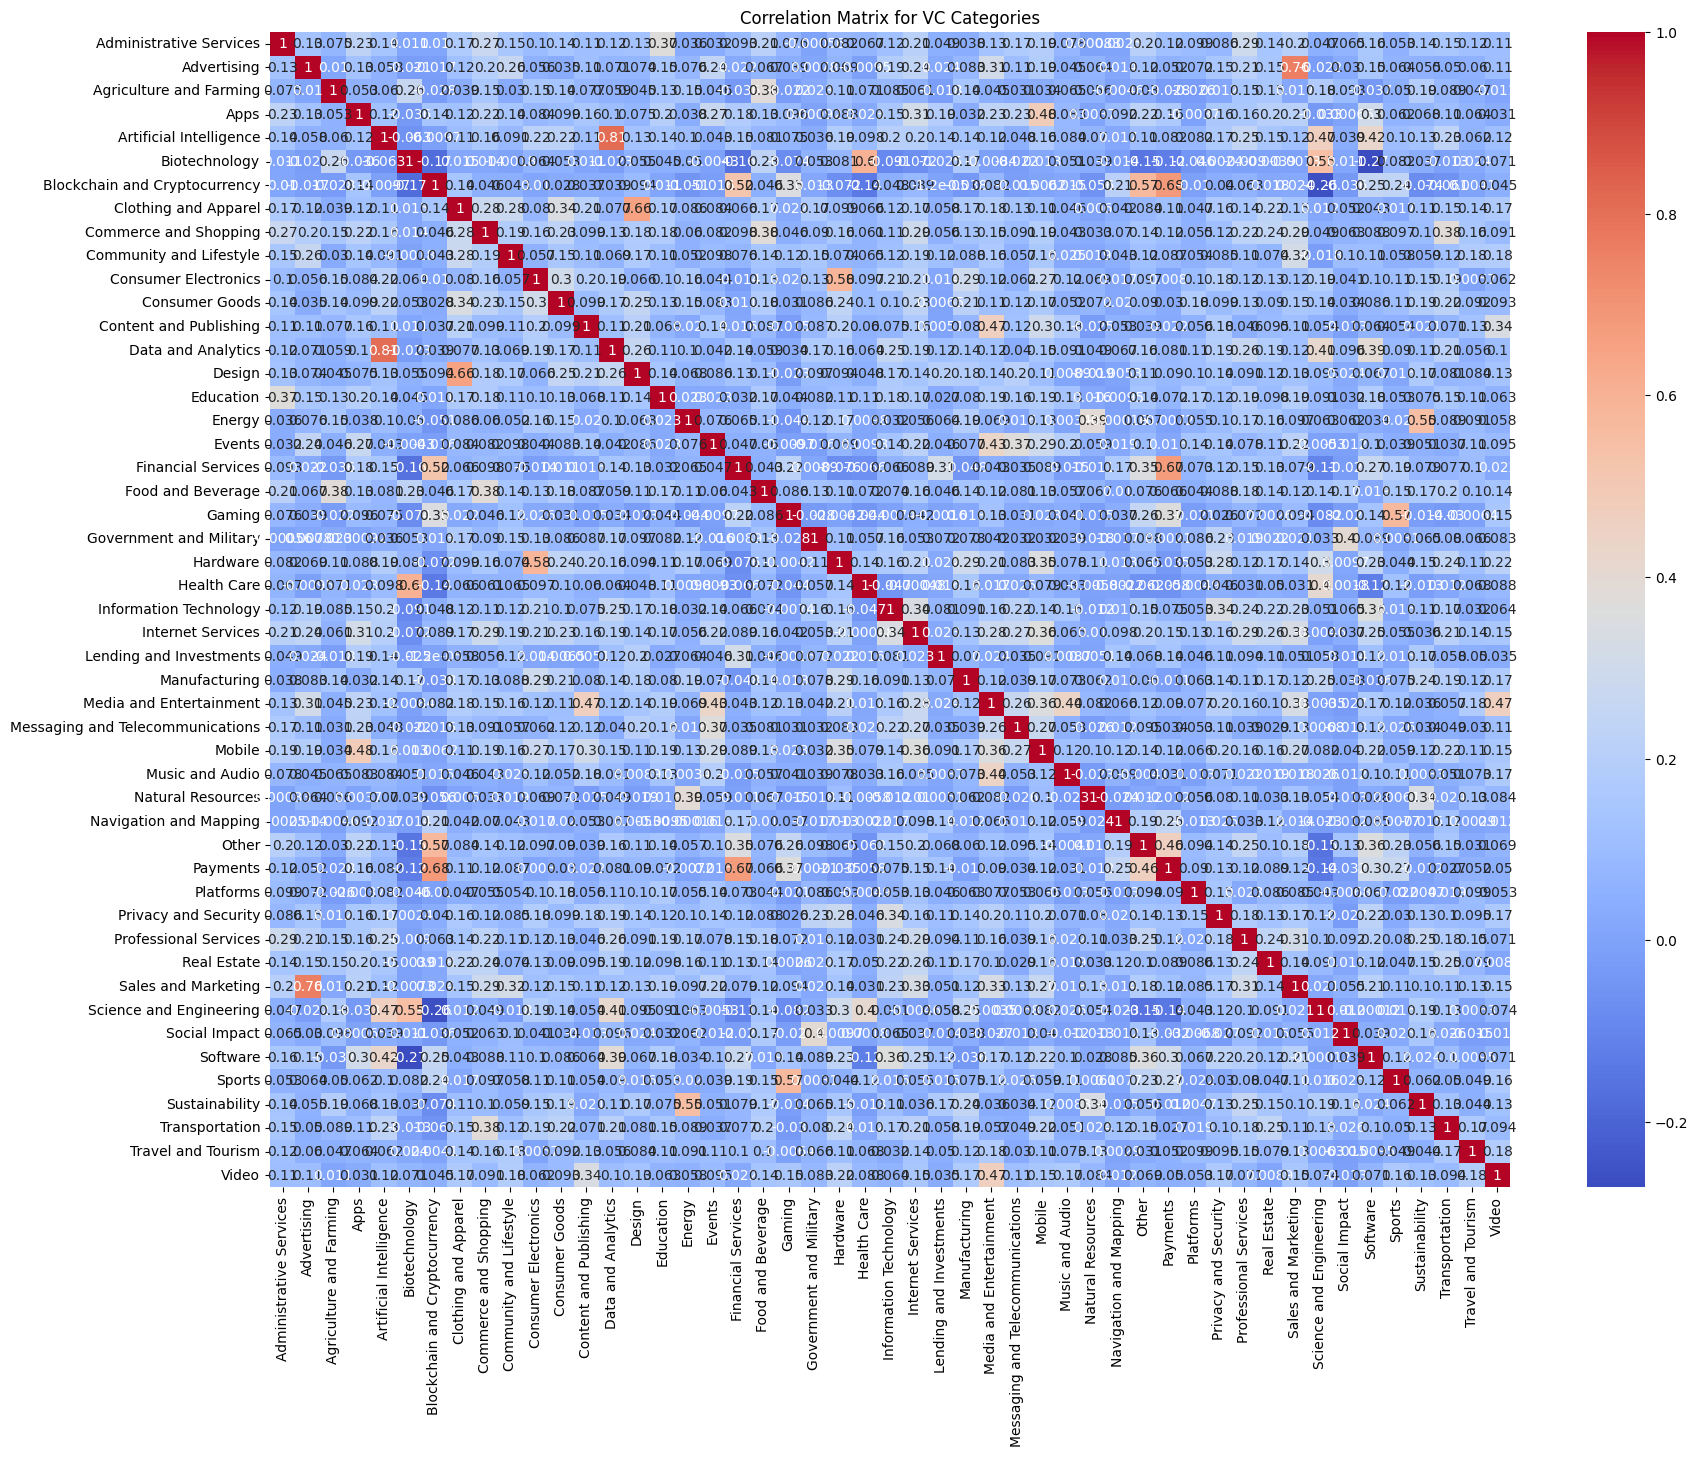

In [18]:
vc_categories_corr_features = vc_investors_w_categories.copy()
vc_categories_corr_features.drop(columns=['investor_uuid', 'all_category_groups_list'], inplace=True)

vc_categories_corr = vc_categories_corr_features.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(vc_categories_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for VC Categories')
plt.show()

**Comments**: 

Categories with strong correlation can be merged:
- Sales and Marketing, Advertising
- Data Analytics, Artificial Intelligence, Science and Engineering
- Mobile, Apps
- Professional Service, Administrative Services
- Media and Entretaiment, Content and Publishing, Video
- Sustainability, Energy, Natural Resources
- Blockchain and Criptocurrency, Financial Services, Payments, Lending and Investments
- Health Care, Biotecnology
- Cloting and Apparel, Design
- Consumer Electronics, Hardware

Other could be taken out

In [19]:
""" Categories to merge:
- Sales and Marketing, Advertising
- Data Analytics, Artificial Intelligence, Science and Engineering
- Mobile, Apps
- Professional Service, Administrative Services
- Media and Entretaiment, Content and Publishing, Video
- Sustainability, Energy, Natural Resources
- Blockchain and Criptocurrency, Financial Services, Payments, Lending and Investments
- Health Care, Biotechnology
- Cloting and Apparel, Design
- Consumer Electronics, Hardware """

vc_investors_w_merged_categories = vc_investors_w_categories.copy()

vc_investors_w_merged_categories['Sales, Marketing, and Advertising'] = vc_investors_w_merged_categories['Sales and Marketing'] | vc_investors_w_merged_categories['Advertising']

vc_investors_w_merged_categories['Data Science and Engineering'] = vc_investors_w_merged_categories['Data and Analytics'] \
    | vc_investors_w_merged_categories['Artificial Intelligence'] \
    | vc_investors_w_merged_categories['Science and Engineering'] \
    | vc_investors_w_merged_categories['Software']

vc_investors_w_merged_categories['Mobile and Apps'] = vc_investors_w_merged_categories['Mobile'] | vc_investors_w_merged_categories['Apps']

vc_investors_w_merged_categories['Professional and Administrative Services'] = vc_investors_w_merged_categories['Professional Services'] | vc_investors_w_merged_categories['Administrative Services']

vc_investors_w_merged_categories['Media, Entertainment, and Content'] = vc_investors_w_merged_categories['Media and Entertainment'] \
    | vc_investors_w_merged_categories['Content and Publishing'] \
    | vc_investors_w_merged_categories['Video']

vc_investors_w_merged_categories['Sustainability and Energy'] = vc_investors_w_merged_categories['Sustainability'] \
    | vc_investors_w_merged_categories['Energy'] \
    | vc_investors_w_merged_categories['Natural Resources']

vc_investors_w_merged_categories['Blockchain and Financial Services'] = vc_investors_w_merged_categories['Blockchain and Cryptocurrency'] \
    | vc_investors_w_merged_categories['Financial Services'] \
    | vc_investors_w_merged_categories['Payments'] \
    | vc_investors_w_merged_categories['Lending and Investments']
    
vc_investors_w_merged_categories['Health Care and Biotechnology'] = vc_investors_w_merged_categories['Health Care'] | vc_investors_w_merged_categories['Biotechnology']

vc_investors_w_merged_categories['Clothing and Design'] = vc_investors_w_merged_categories['Clothing and Apparel'] | vc_investors_w_merged_categories['Design']

vc_investors_w_merged_categories['Consumer Electronics and Hardware'] = vc_investors_w_merged_categories['Consumer Electronics'] | vc_investors_w_merged_categories['Hardware']
    
vc_investors_w_merged_categories.drop(columns=[
    'Sales and Marketing', 'Advertising',
    'Data and Analytics', 'Artificial Intelligence', 'Science and Engineering', 'Software',
    'Mobile', 'Apps',
    'Professional Services','Administrative Services',
    'Media and Entertainment', 'Content and Publishing', 'Video',
    'Sustainability', 'Energy', 'Natural Resources',
    'Blockchain and Cryptocurrency', 'Financial Services', 'Payments', 'Lending and Investments',
    'Health Care', 'Biotechnology',
    'Clothing and Apparel', 'Design',
    'Consumer Electronics', 'Hardware',
    'Other'
], inplace=True)

merged_categories = vc_investors_w_merged_categories.columns[2:]
vc_investors_w_merged_categories

,investor_uuid,all_category_groups_list,Agriculture and Farming,Commerce and Shopping,Community and Lifestyle,Consumer Goods,Education,Events,Food and Beverage,Gaming,...,"Sales, Marketing, and Advertising",Data Science and Engineering,Mobile and Apps,Professional and Administrative Services,"Media, Entertainment, and Content",Sustainability and Energy,Blockchain and Financial Services,Health Care and Biotechnology,Clothing and Design,Consumer Electronics and Hardware
0,b08efc27-da40-505a-6f9d-c9e14247bf36,"Internet Services,Software,Administrative Serv...",0,0,0,0,0,0,0,1,...,0,1,1,1,0,0,1,1,0,1
1,94e4f649-4cc6-8aa3-5e8a-771e50cd9a7f,"Internet Services,Software",0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,e8de4e94-b48c-76f6-3770-aac7e51158f4,"Internet Services,Software,Information Technol...",0,0,0,0,0,0,0,0,...,1,1,0,1,1,0,1,0,1,0
3,93c87ab7-7cee-5c54-9941-104693dbbdba,"Financial Services,Information Technology,Priv...",1,1,1,1,0,0,0,0,...,0,1,1,1,1,0,1,1,1,1
4,0c5d60dc-ffff-4fef-8aa2-5f8e8420ef53,"Energy,Manufacturing,Consumer Electronics,Hard...",1,1,1,1,0,0,1,0,...,0,1,1,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109,3dcca052-30e3-4f70-a352-55e384333785,"Information Technology,Other,Software",0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1110,799f911b-a07b-891a-5be2-5b4d74c11e65,"Education,Information Technology,Other,Software",0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1111,1b65bb47-cdde-47a0-bc20-d119064dcef5,"Community and Lifestyle,Health Care,Informatio...",0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1112,ff82da75-a956-d628-4095-475a24e0df47,"Community and Lifestyle,Health Care,Informatio...",0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## One-Hot Encode VCs' Investment Types
Analyze and encode the types of investments made by venture capitalists to identify patterns and preferences.

In [20]:
investment_types = investments['investment_type'].unique()
print(investment_types)

['series_a' 'seed' 'series_b' 'series_unknown' 'series_c' 'grant'
 'series_d' 'private_equity' 'post_ipo_equity' 'series_e' 'pre_seed'
 'angel' 'convertible_note' 'series_f' 'undisclosed' 'corporate_round'
 'non_equity_assistance' 'equity_crowdfunding' 'post_ipo_debt'
 'secondary_market' 'post_ipo_secondary' 'initial_coin_offering'
 'product_crowdfunding' 'series_g' 'series_h' 'series_i']


In [21]:
vc_investors_w_type = vc_investors.copy()

vc_investors_w_type['all_investment_types_list'] = [[] for _ in range(len(vc_investors_w_type))]

for idx, investor in vc_investors_w_type.iterrows():
    types = df_two_stage_investments[df_two_stage_investments['investor_uuid_y'] == investor.investor_uuid]['investment_type'].dropna()
    vc_investors_w_type.at[idx, 'all_investment_types_list'] = ','.join(types)

In [22]:
for inv_type in investment_types:
    vc_investors_w_type[inv_type] = vc_investors_w_type['all_investment_types_list'].str.contains(inv_type, case=False, na=False).astype(int)

vc_investors_w_type.head()

,investor_uuid,all_investment_types_list,series_a,seed,series_b,series_unknown,series_c,grant,series_d,private_equity,...,non_equity_assistance,equity_crowdfunding,post_ipo_debt,secondary_market,post_ipo_secondary,initial_coin_offering,product_crowdfunding,series_g,series_h,series_i
0,b08efc27-da40-505a-6f9d-c9e14247bf36,"seed,series_b,series_d,series_e,series_b,serie...",1,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,94e4f649-4cc6-8aa3-5e8a-771e50cd9a7f,seed,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,e8de4e94-b48c-76f6-3770-aac7e51158f4,"seed,series_a,series_a,series_unknown,seed,see...",1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,93c87ab7-7cee-5c54-9941-104693dbbdba,"pre_seed,seed,series_unknown,convertible_note,...",1,1,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0c5d60dc-ffff-4fef-8aa2-5f8e8420ef53,"series_unknown,series_a,series_c,series_unknow...",1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


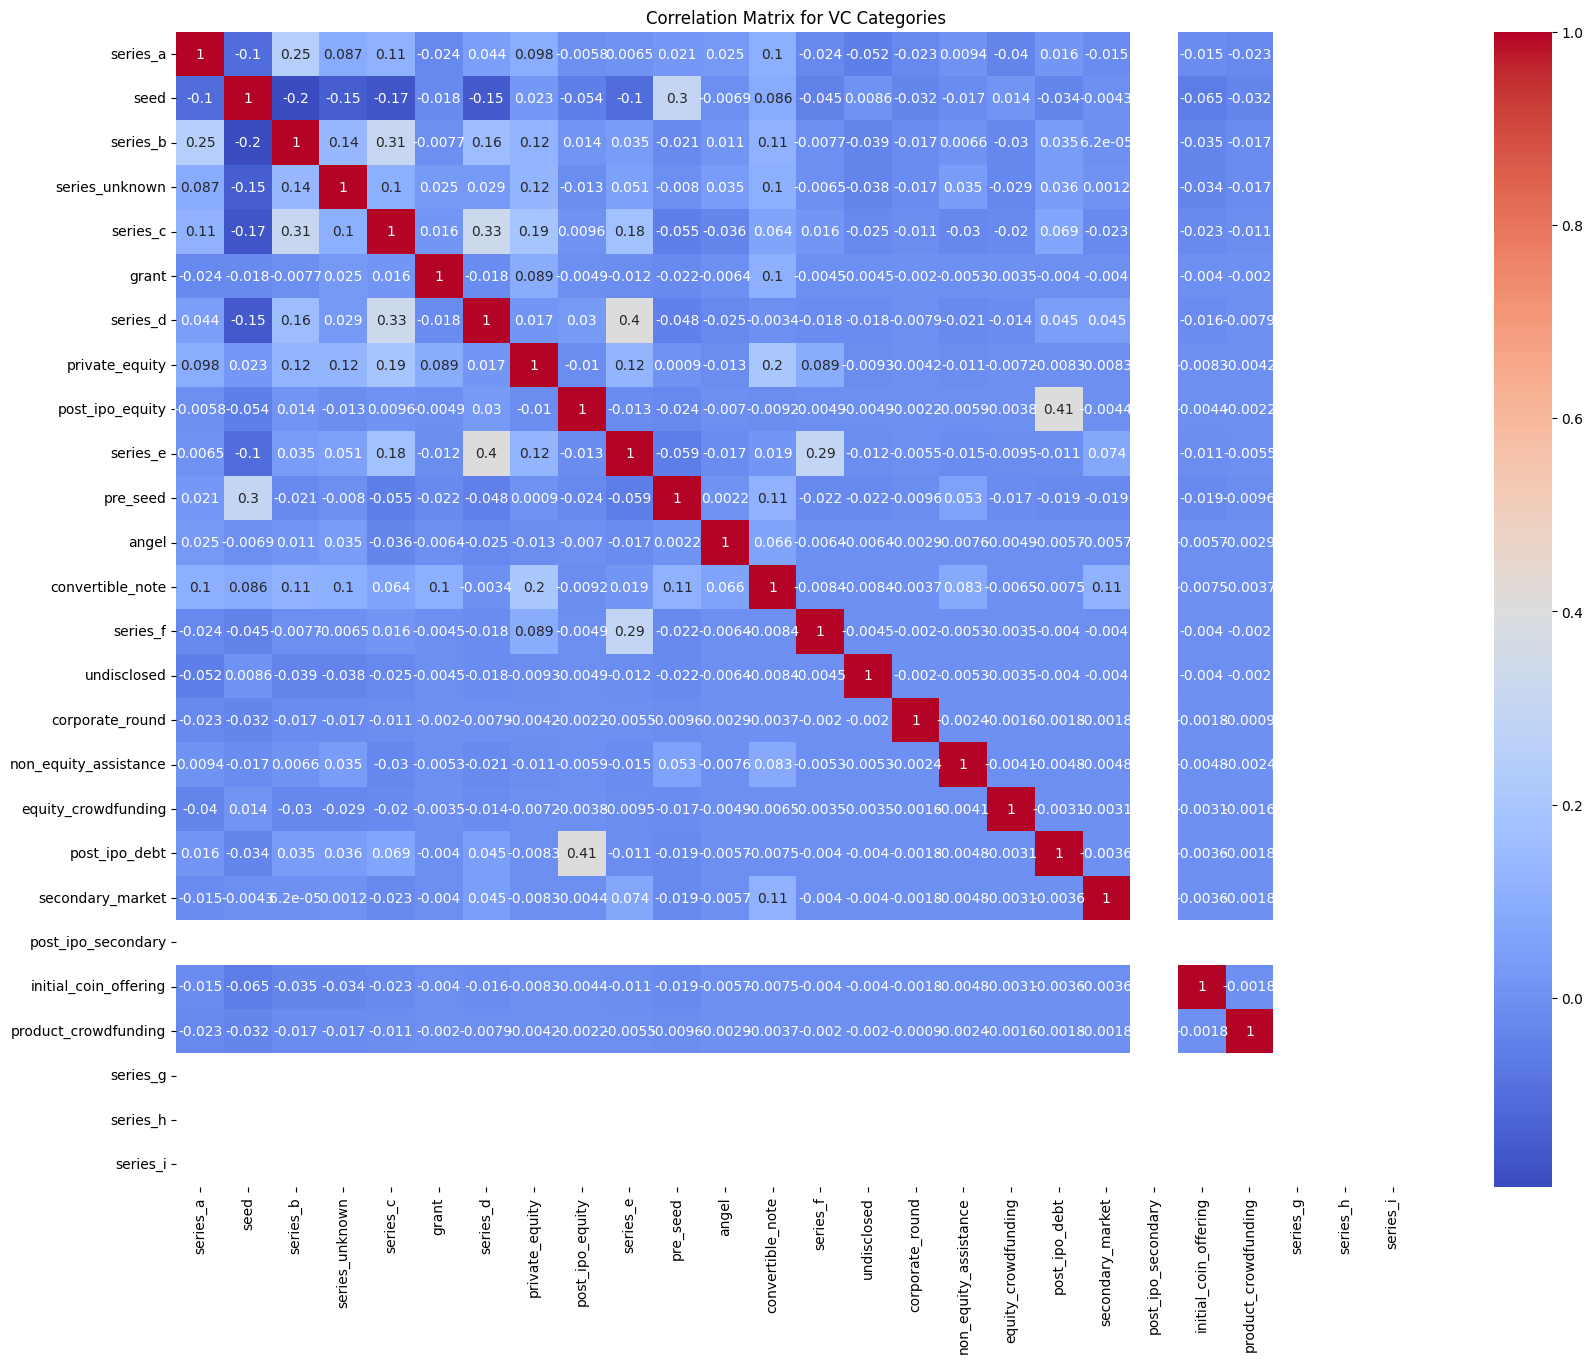

In [23]:
vc_inv_type_corr_features = vc_investors_w_type.copy()
vc_inv_type_corr_features.drop(columns=['investor_uuid', 'all_investment_types_list'], inplace=True)

vc_inv_type_corr = vc_inv_type_corr_features.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(vc_inv_type_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for VC Categories')
plt.show()

**Comments**: no strong relationships in investment types

## Calculate Average Investment Value
Compute statistical metrics such as minimum, maximum, mean, and standard deviation for investment values.

In [24]:
vc_investors_avg_inv = vc_investors.copy()

for idx, investor in vc_investors_avg_inv.iterrows():
    all_usd_inv = vc_investments[vc_investments['investor_uuid'] == investor.investor_uuid]['total_funding_usd'].dropna()
    vc_investors_avg_inv.at[idx, 'min_inv'] = all_usd_inv.min()
    vc_investors_avg_inv.at[idx, 'max_inv'] = all_usd_inv.max()
    vc_investors_avg_inv.at[idx, 'mean_inv'] = all_usd_inv.mean()
    vc_investors_avg_inv.at[idx, 'std_inv'] = all_usd_inv.std()

In [25]:
# Need to drop if max_inv = 0, doesn't make sense
vc_investors_avg_inv.head()

,investor_uuid,min_inv,max_inv,mean_inv,std_inv
0,b08efc27-da40-505a-6f9d-c9e14247bf36,984385.0,815029943.0,2.660598e+08,2.728797e+08
1,94e4f649-4cc6-8aa3-5e8a-771e50cd9a7f,2350000.0,2350000.0,2.350000e+06,NaN
2,e8de4e94-b48c-76f6-3770-aac7e51158f4,150000.0,82524874.0,2.902199e+07,3.132309e+07
3,93c87ab7-7cee-5c54-9941-104693dbbdba,0.0,82272392.0,7.999308e+06,1.254917e+07
4,0c5d60dc-ffff-4fef-8aa2-5f8e8420ef53,2480082.0,440073000.0,5.680185e+07,7.543284e+07


## Add city

Not used...

In [26]:
# vc_investors_w_city = vc_investors.merge(investors[['uuid', 'city']], left_on='investor_uuid', right_on='uuid', how='left').drop(columns='uuid')
vc_investors_w_city = vc_investors.copy()
vc_investors_w_city['city'] = 'A'

vc_investors_w_city.head()

,investor_uuid,city
0,b08efc27-da40-505a-6f9d-c9e14247bf36,A
1,94e4f649-4cc6-8aa3-5e8a-771e50cd9a7f,A
2,e8de4e94-b48c-76f6-3770-aac7e51158f4,A
3,93c87ab7-7cee-5c54-9941-104693dbbdba,A
4,0c5d60dc-ffff-4fef-8aa2-5f8e8420ef53,A


## Calculate Series A to B Metrics
Analyze the transition of companies from Series A to Series B funding rounds, including success ratios and time metrics.

In [27]:
vc_series_a_b_investments = vc_investments[vc_investments['investment_type'].str.contains('series_a|series_b', case=False, na=False)]
vc_series_a_b_investments

,uuid,funding_round_uuid,investor_uuid,is_lead_investor,investor_name,investor_types,investment_count,investor_region,investor_country,investor_founded_year,...,last_funding_year,category_groups_list,short_description,keywords,last_valuation,first_ipo_year,category,investor_ecosystem,syndication,total_funding_by_investor
0,57edc630-2a6e-64be-5b32-a29ab20303f0,f483f638-4140-992f-fb58-fbce7fdd2201,2c8502f9-cf1a-7b91-9f10-7976a1bf753a,True,Mangrove Capital Partners,venture capital,175.0,Luxembourg,Luxembourg,2000.0,...,2007,"Commerce and Shopping,Internet Services",Zlio is a French startup enabling internet use...,the company is a French startup enabling inter...,0.0,inf,Commerce and Shopping,Europe,0,4.789085e+09
1,c684e50f-4772-15a9-5a13-84aaa89001aa,25b142a6-ea15-fe19-c4d1-a6767eacbf2b,d0cdfdc0-517d-ce18-4a74-194f506bccad,True,Balderton Capital,venture capital,429.0,England,United Kingdom,2000.0,...,2009,"Media and Entertainment,Travel and Tourism,Video","TVTrip, an online platform, provides its users...","the company, an online platform, provides its ...",0.0,inf,Media and Entertainment,NaN,1,2.672902e+10
2,3c313f91-d8f9-18b5-0a22-0e4395fb2f86,25b142a6-ea15-fe19-c4d1-a6767eacbf2b,7475db43-36a9-414d-f7a9-b92b78bae47b,True,Partech,venture capital,582.0,Ile-de-France,France,1982.0,...,2009,"Media and Entertainment,Travel and Tourism,Video","TVTrip, an online platform, provides its users...","the company, an online platform, provides its ...",0.0,inf,Media and Entertainment,Europe,1,2.336784e+10
3,7f5df991-c957-2b5e-bc04-014fb4c93a5c,252d36d5-62db-3fb6-b73d-a17762bf1356,7475db43-36a9-414d-f7a9-b92b78bae47b,False,Partech,venture capital,582.0,Ile-de-France,France,1982.0,...,2009,"Advertising,Content and Publishing,Hardware,In...",Dailymotion is the leading destination for vid...,the company is the leading destination for vid...,0.0,inf,Video,Europe,1,2.336784e+10
4,3a50f786-de98-a4a2-b465-18f7684d31b8,252d36d5-62db-3fb6-b73d-a17762bf1356,6f2acf2a-5cbf-adb1-cbb4-5829ab0b08cd,True,Atlas Venture,venture capital,613.0,Massachusetts,United States,1980.0,...,2009,"Advertising,Content and Publishing,Hardware,In...",Dailymotion is the leading destination for vid...,the company is the leading destination for vid...,0.0,inf,Video,NaN,1,3.938525e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23403,f8ae0c37-77fe-4286-9bc2-a08f69ba425b,bbe611f7-7f0b-4fee-8922-06d3b649ce5a,9dda8c60-3517-927f-0c15-4807e7bd6054,NaN,Picus Capital,venture capital,311.0,Bayern,Germany,2015.0,...,2025,"Information Technology,Professional Services,S...",Maki is a skill assessment tool to assess and ...,the company is a skill assessment tool to asse...,0.0,inf,Professional Services,Europe,1,6.529845e+09
23404,defe5d4b-7f61-4a23-be99-b32218262f69,bbe611f7-7f0b-4fee-8922-06d3b649ce5a,4ec367a2-faea-459a-93dd-dab0b1cdd3d4,NaN,Frst,venture capital,51.0,Ile-de-France,France,2019.0,...,2025,"Information Technology,Professional Services,S...",Maki is a skill assessment tool to assess and ...,the company is a skill assessment tool to asse...,0.0,inf,Professional Services,Europe,1,2.488405e+09
23405,9c430091-00ec-414c-a641-eed3d15d5480,bbe611f7-7f0b-4fee-8922-06d3b649ce5a,aefa3a84-5193-00c3-5cbf-ec5ec2645672,NaN,Global Founders Capital,"private equity firm,venture capital",995.0,Berlin,Germany,2013.0,...,2025,"Information Technology,Professional Services,S...",Maki is a skill assessment tool to assess and ...,the company is a skill assessment tool to asse...,0.0,inf,Professional Services,Europe,1,6.662956e+10
23406,9898e015-d3b5-45b3-b507-1c4964c4083c,bbe611f7-7f0b-4fee-8922-06d3b649ce5a,294f6e84-bc03-47cb-9e30-2e5bd3b768f3,True,Blossom Capital,venture capital,51.0,England,United Kingdom,2018.0,...,2025,"Information Technology,Professional Services,S...",Maki is a skill assessment tool to assess and ...,the company is a skill assessment tool to asse...,0.0,inf,Professional Services,NaN,1,3.908283e+09


In [28]:
companies_series_a_b = pd.DataFrame(vc_series_a_b_investments['org_uuid'].unique(), columns=['org_uuid'])
companies_series_a_b

""" companies_series_a_b = companies_series_a_b.merge(
    vc_series_a_b_investments[vc_series_a_b_investments['investment_type'] == 'seed'][['announced_year', 'org_uuid']],
    left_on='org_uuid', 
    right_on='org_uuid', 
    how='left'
).rename(columns={'announced_year': 'seed_year'}) """

companies_series_a_b = companies_series_a_b.merge(
    vc_series_a_b_investments[vc_series_a_b_investments['investment_type'] == 'series_a'][['announced_year', 'org_uuid']],
    left_on='org_uuid', 
    right_on='org_uuid', 
    how='left'
).rename(columns={'announced_year': 'series_a_year'})

companies_series_a_b = companies_series_a_b.merge(
    vc_series_a_b_investments[vc_series_a_b_investments['investment_type'] == 'series_b'][['announced_year', 'org_uuid']],
    left_on='org_uuid', 
    right_on='org_uuid', 
    how='left'
).rename(columns={'announced_year': 'series_b_year'})

companies_series_a_b = companies_series_a_b[companies_series_a_b['series_a_year'].isna() == False]
companies_series_a_b['time_a_to_b'] = companies_series_a_b['series_b_year'] - companies_series_a_b['series_a_year']
companies_series_a_b['success'] = (~((companies_series_a_b['series_a_year'] < 2020) & (companies_series_a_b['series_b_year'].isna()))).astype(int)

companies_series_a_b

,org_uuid,series_a_year,series_b_year,time_a_to_b,success
0,bbb6b150-639e-1b33-728d-0cfa1ffc9597,2007.0,NaN,NaN,0
1,a0f5e737-d973-703c-7f66-0fc31d0e4b5b,2007.0,2009.0,2.0,1
2,a0f5e737-d973-703c-7f66-0fc31d0e4b5b,2007.0,2009.0,2.0,1
3,a0f5e737-d973-703c-7f66-0fc31d0e4b5b,2007.0,2009.0,2.0,1
4,a0f5e737-d973-703c-7f66-0fc31d0e4b5b,2007.0,2009.0,2.0,1
...,...,...,...,...,...
5667,bb4c183f-07cc-44f9-9ac5-a45ca6ad057c,2025.0,NaN,NaN,1
5668,52c65dae-847e-4157-ac79-1c62eb754b8d,2025.0,NaN,NaN,1
5669,52c65dae-847e-4157-ac79-1c62eb754b8d,2025.0,NaN,NaN,1
5670,52c65dae-847e-4157-ac79-1c62eb754b8d,2025.0,NaN,NaN,1


In [29]:
vc_investors_w_time_a_to_b = vc_investors.copy()

for idx, investor in vc_investors_w_time_a_to_b.iterrows():
    companies_invested_uuid = vc_investments[vc_investments['investor_uuid'] == investor.investor_uuid]['org_uuid']
    companies_invested = companies_series_a_b[companies_series_a_b['org_uuid'].isin(companies_invested_uuid)]

    vc_investors_w_time_a_to_b.at[idx, 'success_ratio'] = companies_invested['success'].mean()
    vc_investors_w_time_a_to_b.at[idx, 'avg_time_a_to_b'] = companies_invested['time_a_to_b'].mean()
    vc_investors_w_time_a_to_b.at[idx, 'std_time_a_to_b'] = companies_invested['time_a_to_b'].std()
    
vc_investors_w_time_a_to_b

,investor_uuid,success_ratio,avg_time_a_to_b,std_time_a_to_b
0,b08efc27-da40-505a-6f9d-c9e14247bf36,0.994012,0.987654,1.587950
1,94e4f649-4cc6-8aa3-5e8a-771e50cd9a7f,NaN,NaN,NaN
2,e8de4e94-b48c-76f6-3770-aac7e51158f4,0.918033,1.500000,0.833740
3,93c87ab7-7cee-5c54-9941-104693dbbdba,0.982143,NaN,NaN
4,0c5d60dc-ffff-4fef-8aa2-5f8e8420ef53,0.964706,2.853403,1.200647
...,...,...,...,...
1109,3dcca052-30e3-4f70-a352-55e384333785,1.000000,2.333333,0.485071
1110,799f911b-a07b-891a-5be2-5b4d74c11e65,0.953488,1.360000,0.489898
1111,1b65bb47-cdde-47a0-bc20-d119064dcef5,NaN,NaN,NaN
1112,ff82da75-a956-d628-4095-475a24e0df47,NaN,NaN,NaN


## UMAP Embedding
Use UMAP (Uniform Manifold Approximation and Projection) to reduce the dimensionality of the dataset for visualization and clustering.

### Merge data

In [30]:
vc_full_data = vc_investors.merge(
        vc_investors_w_merged_categories, on='investor_uuid'
    ).merge(
        vc_investors_w_type, on='investor_uuid'
    ).merge(
        vc_investors_avg_inv, on='investor_uuid'
    ).merge(
        vc_investors_w_gini, on='investor_uuid'
    ).merge(
        vc_investors_w_time_a_to_b, on='investor_uuid'
    )
    
vc_full_data = vc_full_data[vc_full_data['max_inv'] != 0]
vc_full_data = vc_full_data[vc_full_data['std_inv'] != 0]
vc_full_data = vc_full_data[vc_full_data['std_time_a_to_b'] != 0]
vc_full_data.drop(columns=['investor_uuid', 'all_category_groups_list', 'all_investment_types_list', 'max_inv', 'min_inv', 'std_inv', 'std_time_a_to_b'], inplace=True)
vc_full_data = vc_full_data.dropna()

categorical_columns = [i for i, col in enumerate(vc_full_data.columns) if set(vc_full_data[col].unique()) <= {0, 1}]
# categorical_columns.append(vc_full_data.columns.size - 1)

numerical_columns = [i for i in range(vc_full_data.shape[1]) if i not in categorical_columns]

print("Categorical Columns:", categorical_columns)
print("Numerical Columns:", numerical_columns)

vc_full_data.head()

Categorical Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
Numerical Columns: [58, 59, 60, 61]


,Agriculture and Farming,Commerce and Shopping,Community and Lifestyle,Consumer Goods,Education,Events,Food and Beverage,Gaming,Government and Military,Information Technology,...,post_ipo_secondary,initial_coin_offering,product_crowdfunding,series_g,series_h,series_i,mean_inv,selectivity_gini,success_ratio,avg_time_a_to_b
0,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,2.660598e+08,0.137827,0.994012,0.987654
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,2.902199e+07,0.150000,0.918033,1.500000
4,1,1,1,1,0,0,1,0,1,1,...,0,0,0,0,0,0,5.680185e+07,0.347767,0.964706,2.853403
5,1,1,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,8.054529e+06,0.376728,0.816667,3.466667
10,0,1,1,0,1,0,1,0,1,1,...,0,0,0,0,0,0,5.511342e+07,0.267720,0.920091,-0.578804


### Embbed features

In [31]:
#Preprocessing numerical
categorical_data = vc_full_data.iloc[:, categorical_columns]
numerical_data = vc_full_data.iloc[:, numerical_columns]

for c in numerical_data.columns:
    pt = PowerTransformer()
    numerical_data.loc[:, c] = pt.fit_transform(np.array(numerical_data[c]).reshape(-1, 1) )

vc_transformed_data = pd.concat([numerical_data, categorical_data], axis=1)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
# categorical_weight = len(categorical_data.columns) / vc_full_data.shape[1]
categorical_weight = 0.5

#Embedding numerical & categorical
fit1 = umap.UMAP().fit(numerical_data)
fit2 = umap.UMAP().fit(categorical_data)

#Augmenting the numerical embedding with categorical
intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)
embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False, densmap_kwds={}, output_dens=False)

C:\Users\joaom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\joaom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [32]:
vc_embedding = embedding[0]
vc_embedding

array([[-0.5723312 ,  1.5837873 ],
       [ 6.9433923 ,  3.8868477 ],
       [ 7.137476  ,  0.8541677 ],
       [ 8.015684  ,  4.8480926 ],
       [ 9.195737  ,  4.7438884 ],
       [-1.5596164 ,  7.4949617 ],
       [ 7.7262325 ,  2.5953023 ],
       [ 6.8667254 ,  2.9725373 ],
       [ 7.6134586 ,  2.7464302 ],
       [ 1.3822755 ,  4.255463  ],
       [ 9.427194  ,  3.7280855 ],
       [ 6.791794  ,  1.1503838 ],
       [ 6.9177065 ,  0.9792006 ],
       [ 6.181503  ,  1.8361286 ],
       [ 3.111186  ,  3.850746  ],
       [ 8.985569  ,  3.4559257 ],
       [ 4.7010684 ,  1.8296223 ],
       [ 9.408165  ,  4.99228   ],
       [ 7.640497  ,  3.648556  ],
       [ 5.471628  ,  3.264191  ],
       [ 1.8877921 ,  1.0490205 ],
       [ 9.517446  ,  3.0437164 ],
       [ 7.466511  ,  3.226274  ],
       [ 6.847475  ,  3.8847349 ],
       [ 9.120934  ,  3.4849126 ],
       [ 3.7147365 ,  1.068551  ],
       [ 5.506098  ,  1.9546955 ],
       [ 5.3198767 ,  5.132034  ],
       [ 5.217118  ,

C:\Users\joaom\AppData\Local\Temp\ipykernel_22704\3803023798.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


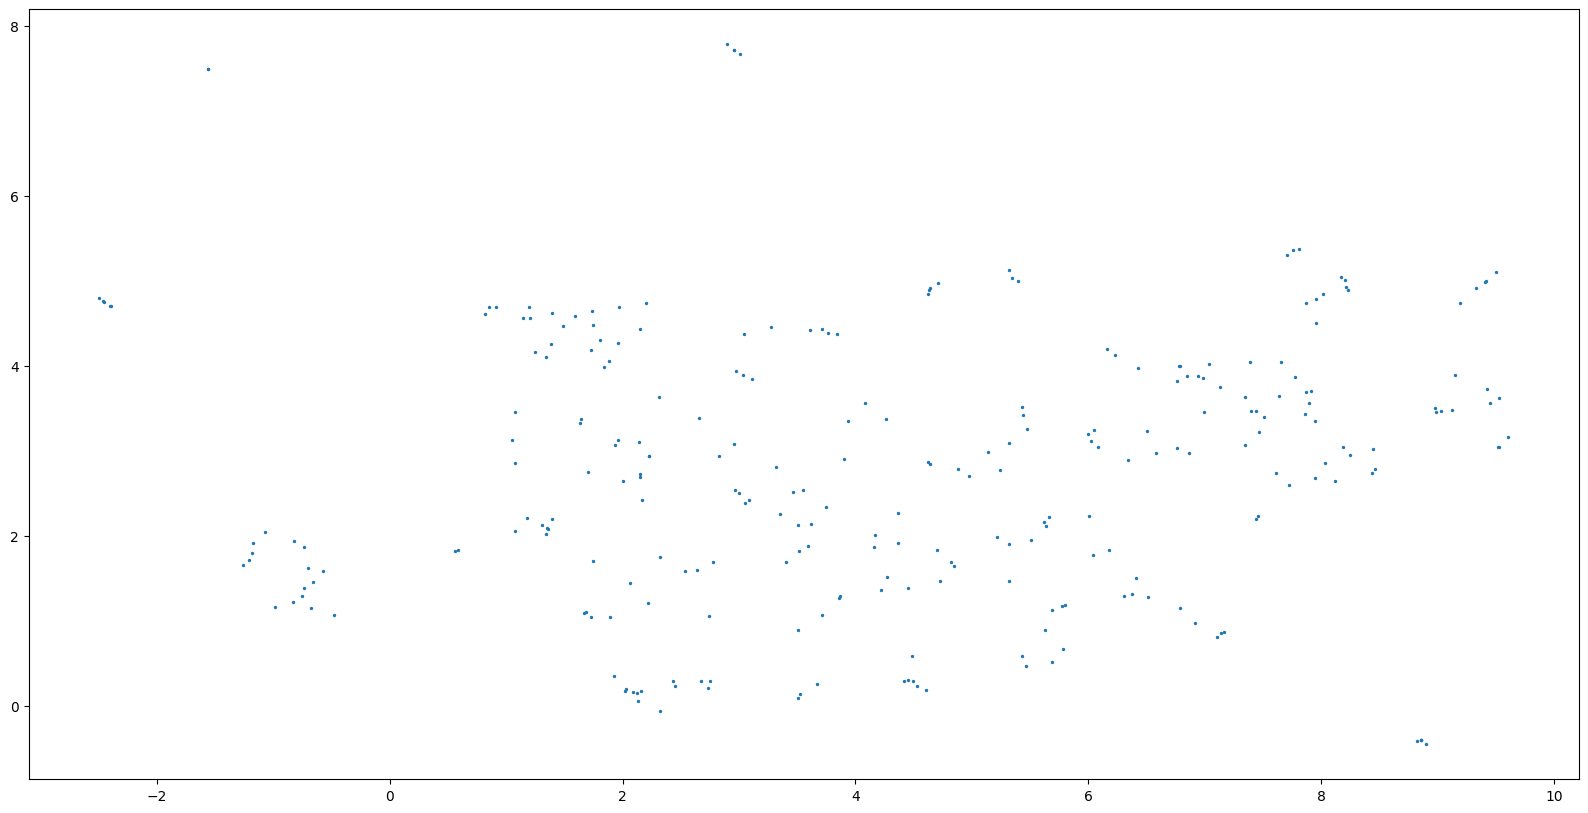

In [33]:
plt.figure(figsize=(20, 10))
plt.scatter(
    vc_embedding[:, 0], vc_embedding[:, 1],
    s=2, cmap='Spectral', alpha=1.0)
plt.show()

## Cluster
Apply clustering algorithms to group venture capitalists based on their investment behaviors and characteristics.

In [34]:
num_of_clusters = 6

### Kmodes
Use the KModes algorithm to cluster categorical data and identify distinct groups of venture capitalists.

In [35]:
kmodes_data = vc_transformed_data.copy()
kmodes_data = kmodes_data.rename(str,axis="columns")

In [36]:
sse = {}

for k in tqdm(range(2, 50)):
    kmodes = KModes(n_clusters=k, max_iter=1000).fit(kmodes_data)
    sse[k] = kmodes.cost_ # Inertia: Sum of distances of samples to their closest cluster center

100%|██████████| 48/48 [00:13<00:00,  3.47it/s]


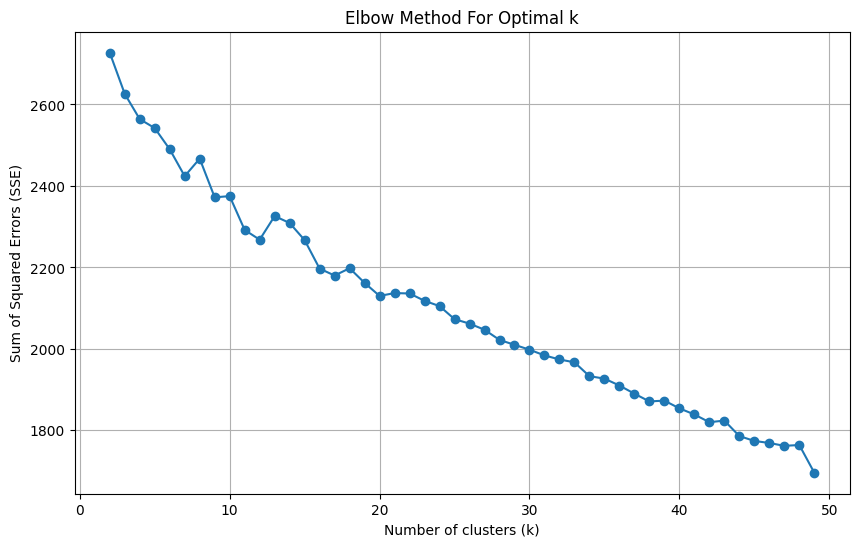

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

In [38]:
kmodes = KModes(n_clusters=num_of_clusters, init='Huang', random_state=42).fit(kmodes_data)
kmodes_labels = kmodes.labels_

pd.Series(kmodes_labels).value_counts()

0    89
5    62
1    38
2    33
3    31
4    24
Name: count, dtype: int64

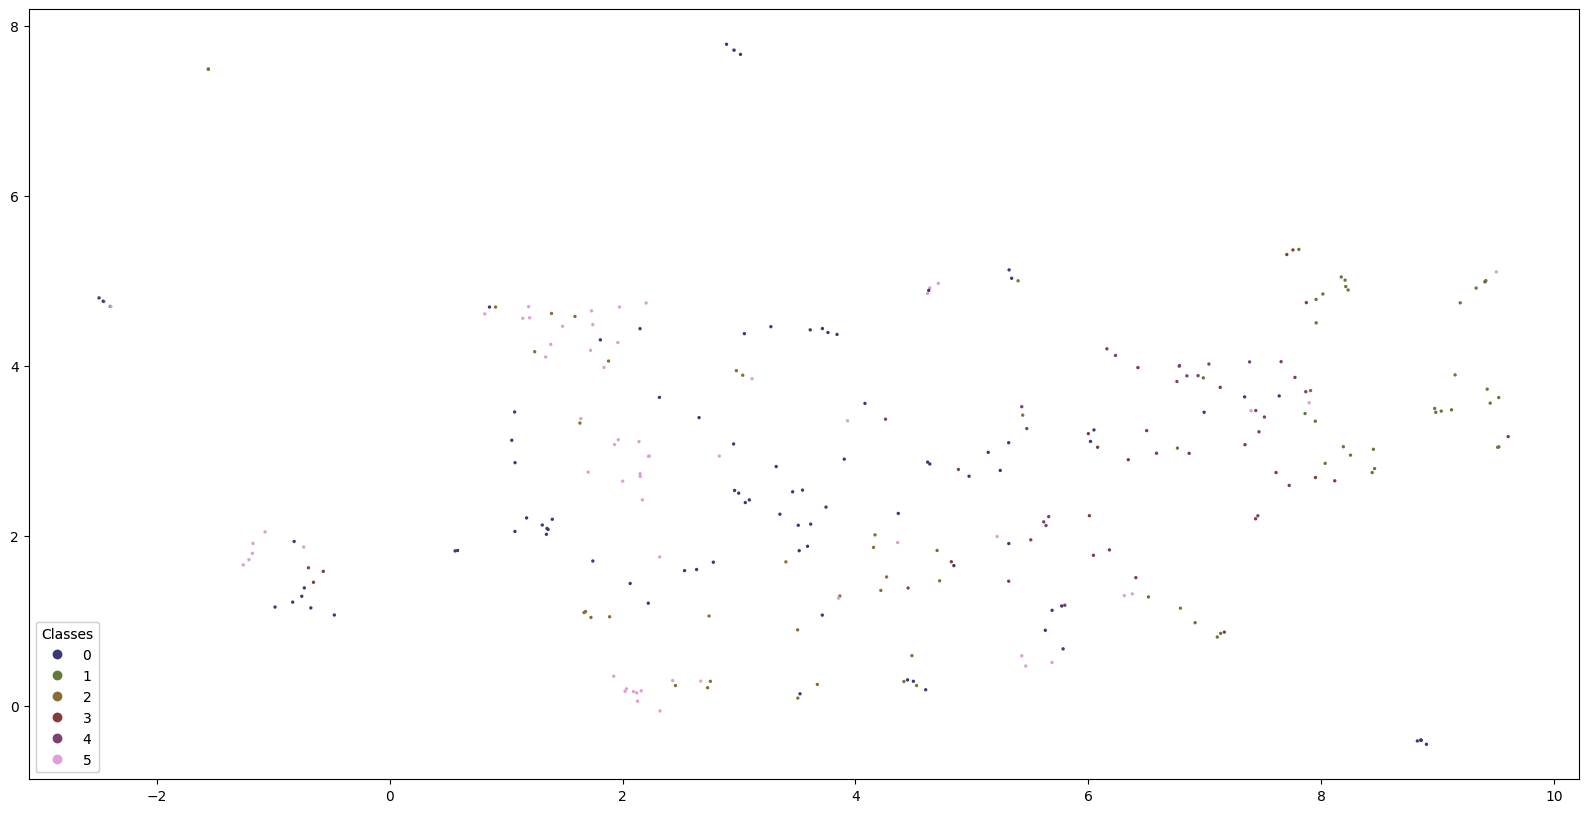

In [39]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(vc_embedding[:, 0], vc_embedding[:, 1], s=2, c=kmodes_labels, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=num_of_clusters), loc="lower left", title="Classes")
ax.add_artist(legend1)

### K-Prototypes
Combine numerical and categorical data using the K-Prototypes algorithm to create mixed-type clusters.

In [40]:
kprot_data = vc_full_data.copy()

In [41]:
sse = {}

for k in tqdm(range(2, 50)):
    kproto = KPrototypes(n_clusters = k, init='Cao').fit(kprot_data, categorical = categorical_columns)
    sse[k] = kproto.cost_ # Inertia: Sum of distances of samples to their closest cluster center

 15%|█▍        | 7/48 [00:14<01:24,  2.06s/it]


KeyboardInterrupt: 

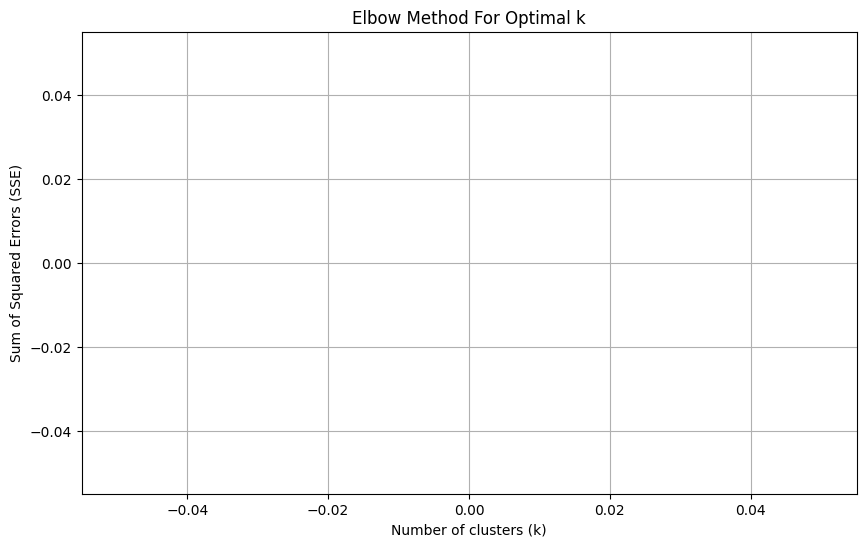

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

In [ ]:
kproto = KPrototypes(n_clusters = num_of_clusters, init='Huang', n_jobs = 10, random_state=42).fit(kprot_data, categorical = categorical_columns)
# clusters = kproto.fit_predict(kprot_data, categorical=categorical_columns)

kproto_labels = kproto.labels_

pd.Series(kproto_labels).value_counts()

2    149
3     73
0     22
5     15
1     12
4      6
Name: count, dtype: int64

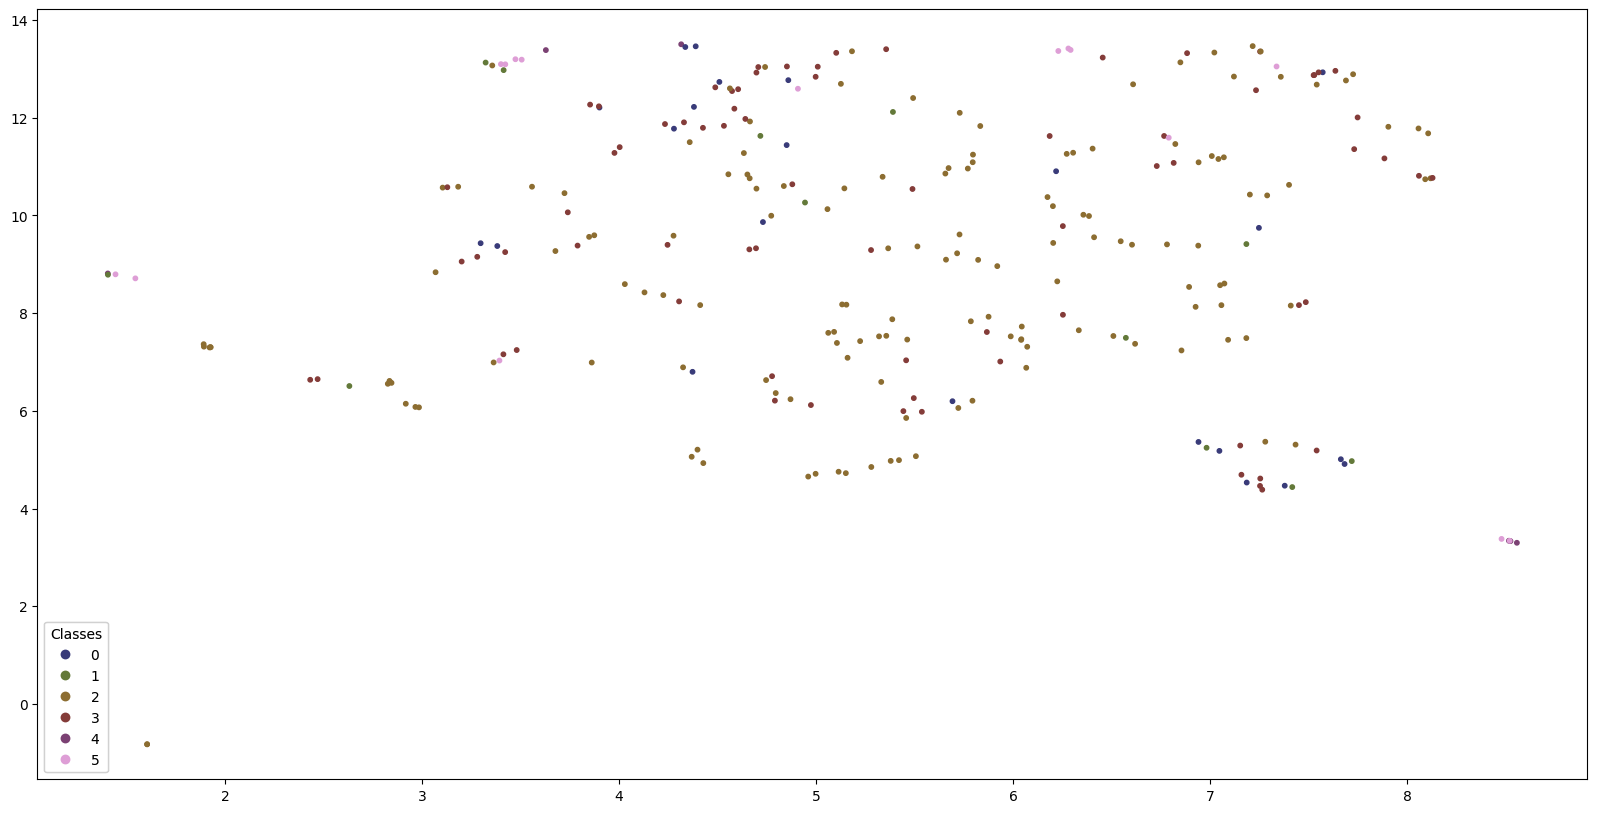

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(vc_embedding[:, 0], vc_embedding[:, 1], s=10, c=kproto_labels, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=num_of_clusters), loc="lower left", title="Classes")
ax.add_artist(legend1)

In [ ]:
clustered_vc_data = vc_full_data.copy()
clustered_vc_data['kproto_cluster'] = kproto_labels

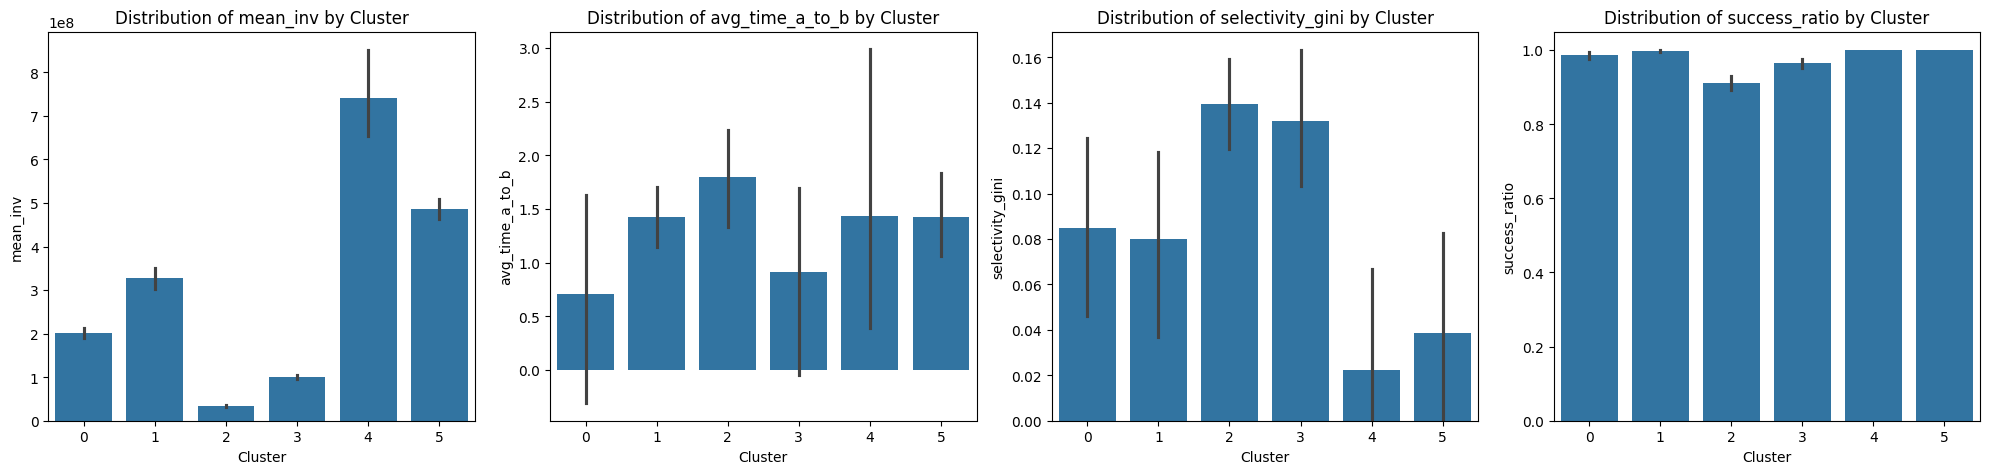

In [ ]:
numerical_columns = ['mean_inv', 'avg_time_a_to_b', 'selectivity_gini', 'success_ratio']

# Plot the distribution of numerical columns for each cluster
fig, axes = plt.subplots(nrows=1, ncols=len(numerical_columns), figsize=(20, 5))
axes = axes.flatten()

for i, column in enumerate(numerical_columns):
    ax = axes[i]
    sns.barplot(x='kproto_cluster', y=column, data=clustered_vc_data, ax=ax)
    ax.set_title(f'Distribution of {column} by Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(column)

plt.tight_layout()
plt.show()

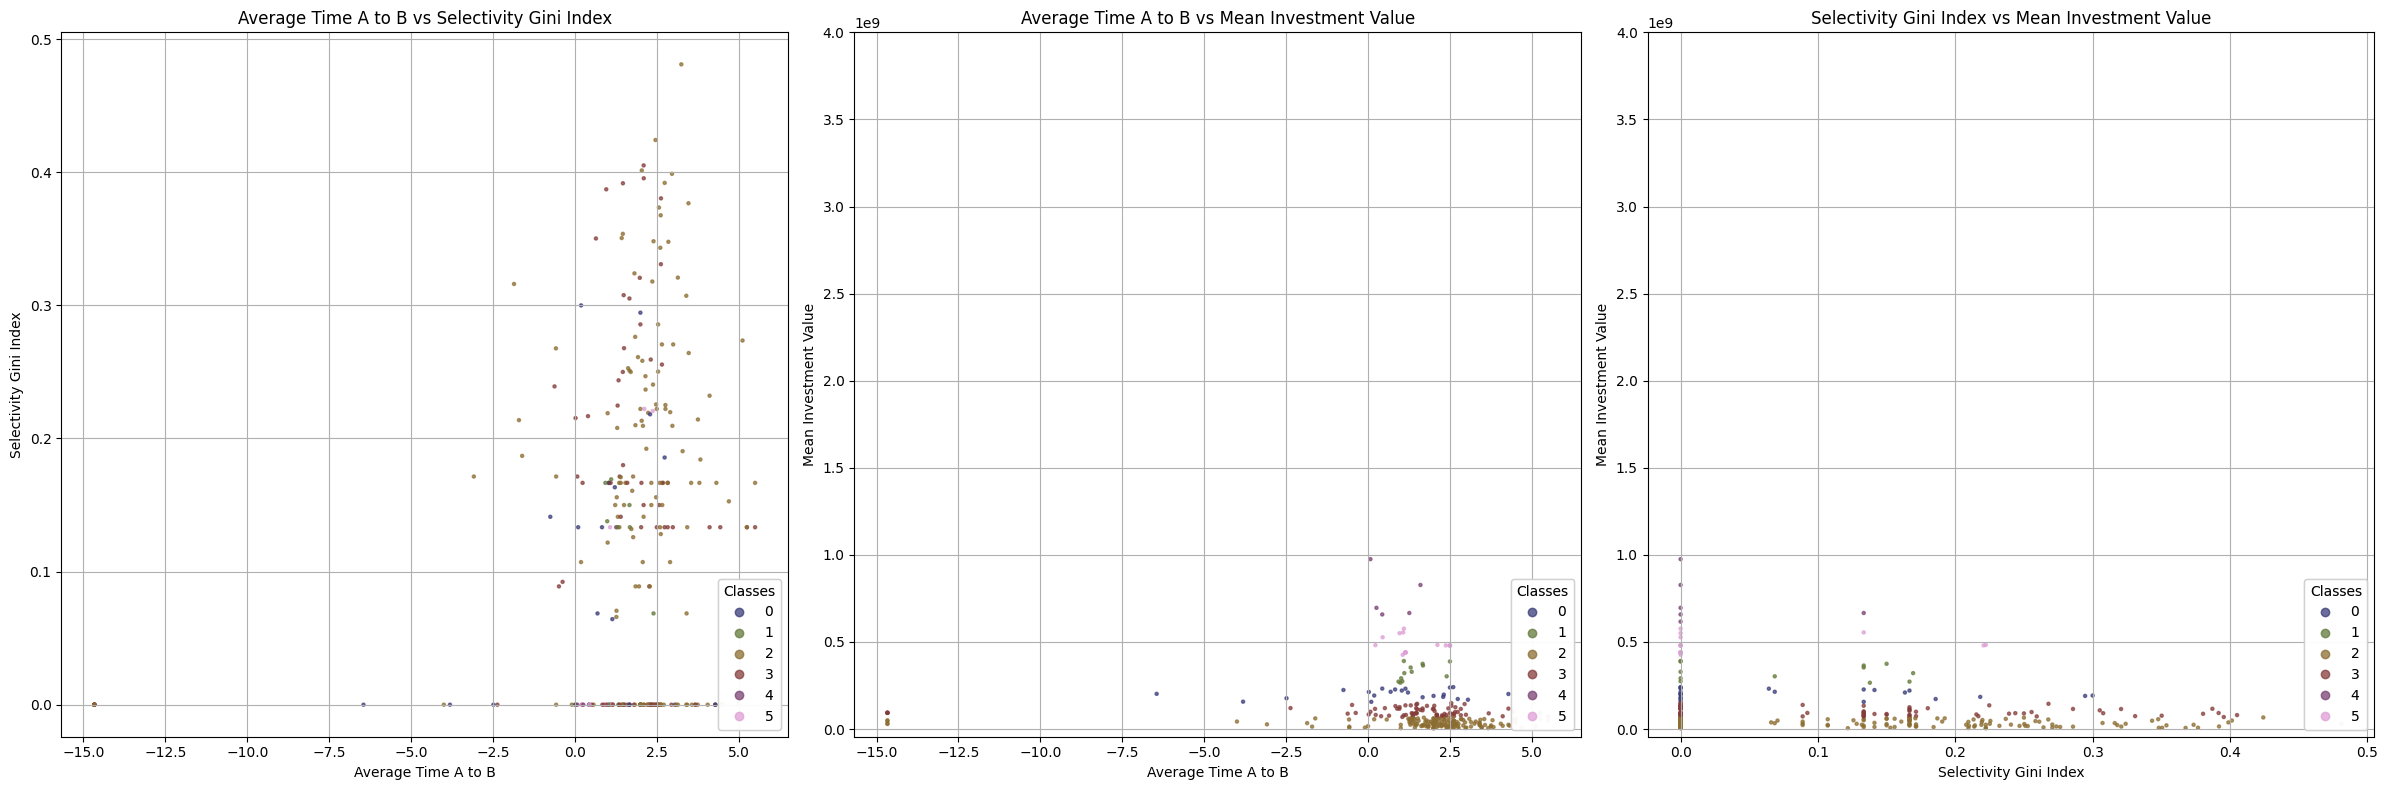

In [ ]:
# Assuming vc_full_data already has the cluster labels
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))

point_size = 5
max_inv_lim = 0.4E10

# First plot
scatter0 = axes[0].scatter(
    vc_full_data['avg_time_a_to_b'], 
    vc_full_data['selectivity_gini'], 
    c=kproto_labels, 
    s=point_size,
    cmap='tab20b', 
    alpha=0.7
)
axes[0].set_xlabel('Average Time A to B')
axes[0].set_ylabel('Selectivity Gini Index')
axes[0].set_title('Average Time A to B vs Selectivity Gini Index')
axes[0].grid(True)
legend0 = axes[0].legend(*scatter0.legend_elements(num=num_of_clusters), loc="lower right", title="Classes")
axes[0].add_artist(legend0)

# Second plot
scatter1 = axes[1].scatter(
    vc_full_data['avg_time_a_to_b'], 
    vc_full_data['mean_inv'], 
    c=kproto_labels, 
    s=point_size,
    cmap='tab20b', 
    alpha=0.7,
)
axes[1].set_xlabel('Average Time A to B')
axes[1].set_ylabel('Mean Investment Value')
axes[1].set_title('Average Time A to B vs Mean Investment Value')
axes[1].grid(True)
axes[1].set_ylim(top=max_inv_lim)
legend1 = axes[1].legend(*scatter1.legend_elements(num=num_of_clusters), loc="lower right", title="Classes")
axes[1].add_artist(legend1)

# Third plot
scatter2 = axes[2].scatter(
    vc_full_data['selectivity_gini'], 
    vc_full_data['mean_inv'], 
    c=kproto_labels, 
    s=point_size,
    cmap='tab20b', 
    alpha=0.7
)
axes[2].set_xlabel('Selectivity Gini Index')
axes[2].set_ylabel('Mean Investment Value')
axes[2].set_title('Selectivity Gini Index vs Mean Investment Value')
axes[2].grid(True)
axes[2].set_ylim(top=max_inv_lim)
legend2 = axes[2].legend(*scatter2.legend_elements(num=num_of_clusters), loc="lower right", title="Classes")
axes[2].add_artist(legend2)

plt.tight_layout()
plt.show()

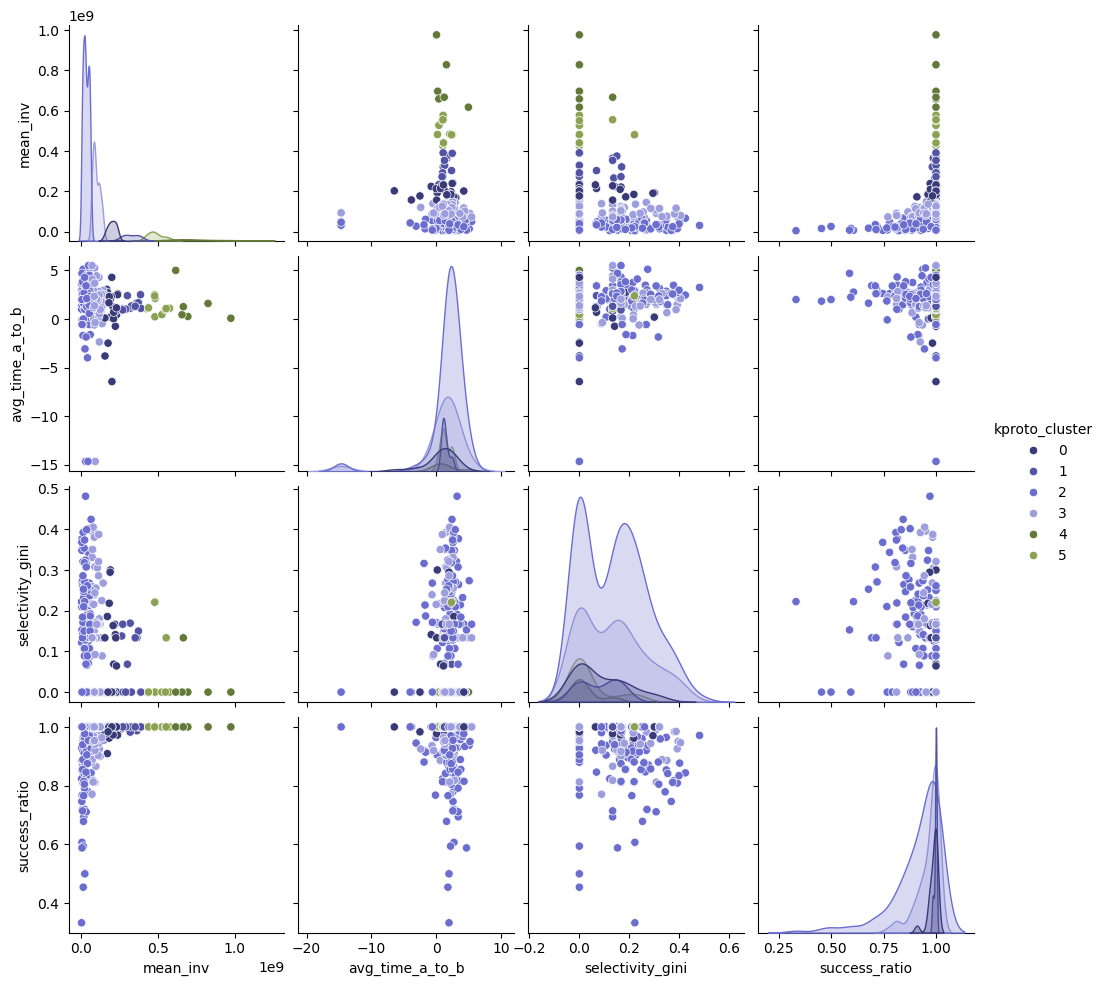

In [ ]:
columns_to_plot = ['mean_inv', 'avg_time_a_to_b', 'selectivity_gini', 'success_ratio']
vc_full_data['kproto_cluster'] = kproto_labels

sns.pairplot(vc_full_data[columns_to_plot + ['kproto_cluster']], hue='kproto_cluster', palette='tab20b')
plt.show()

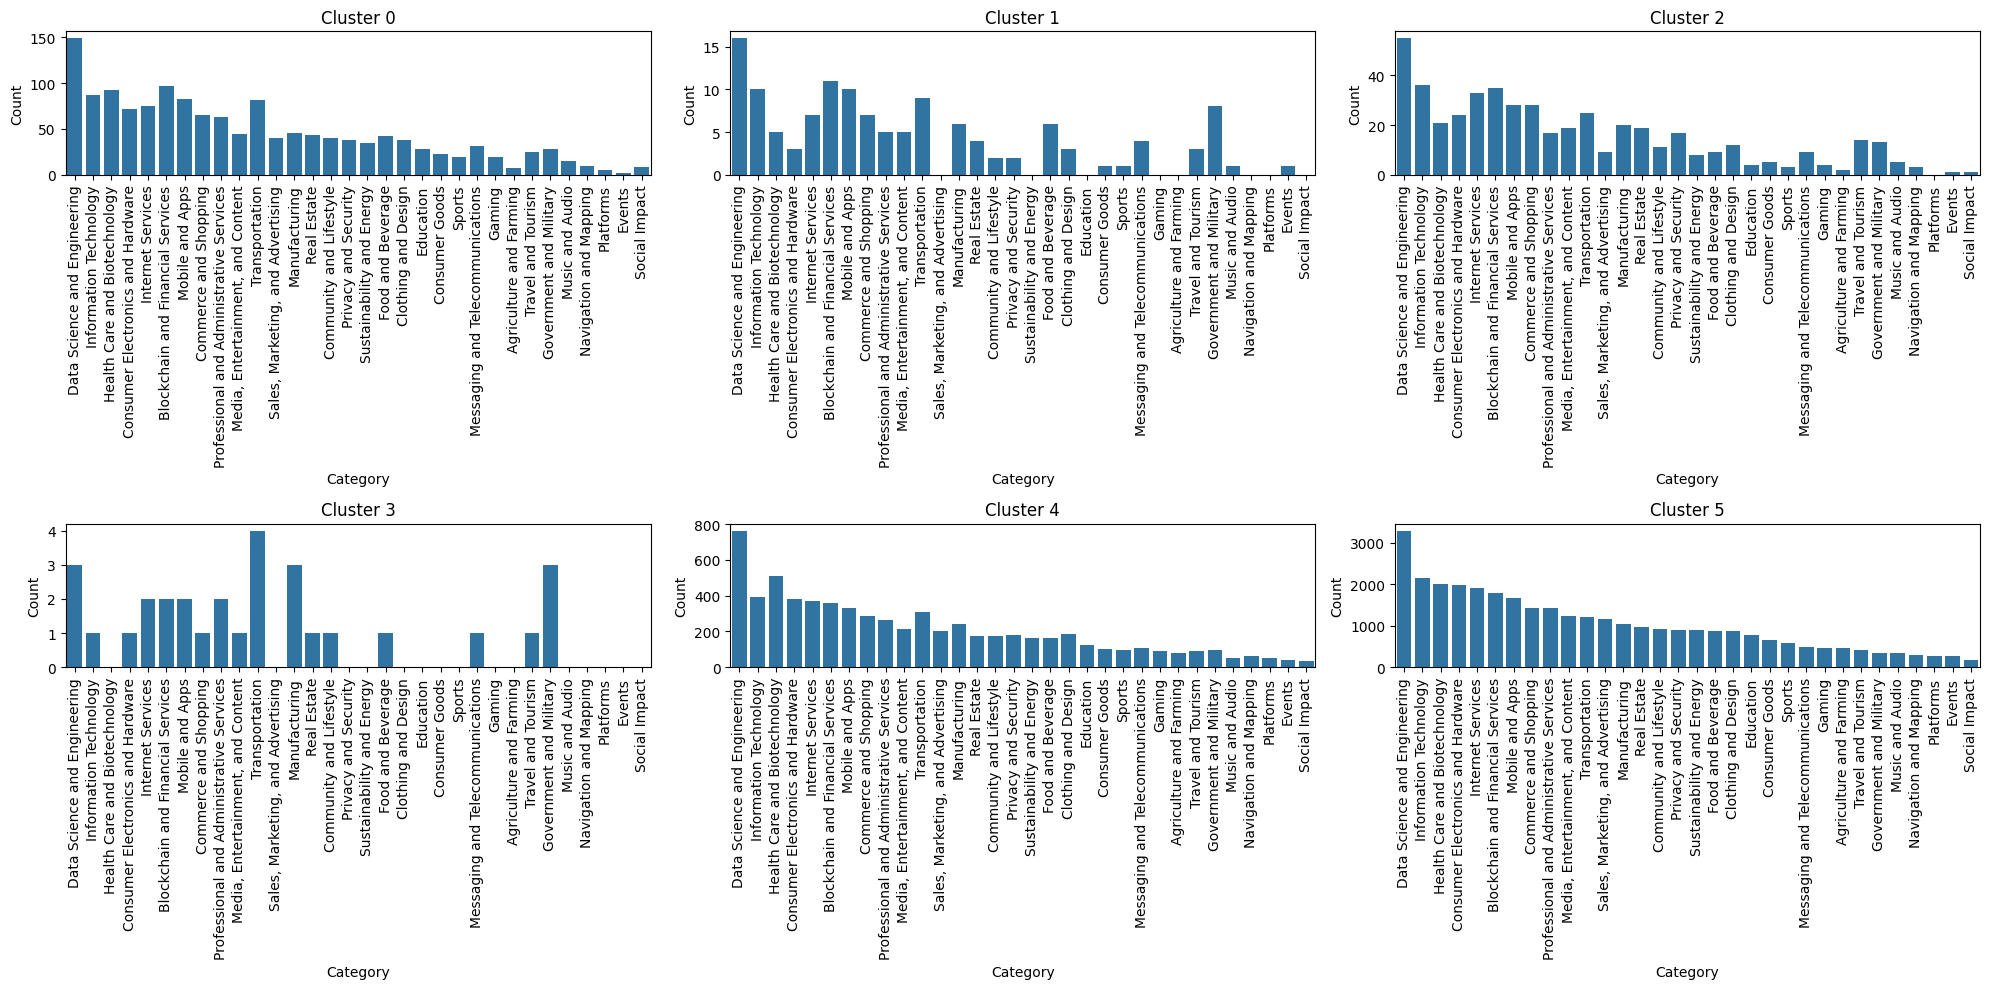

In [ ]:
# Plot the distribution of categories for each cluster
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
axes = axes.flatten()

base_cluster = 5
categories_plot_order = clustered_vc_data[clustered_vc_data['kproto_cluster'] == base_cluster][merged_categories].sum().sort_values(ascending=False)

for cluster_label in range(num_of_clusters):
    ax = axes[cluster_label]
    cluster_data = clustered_vc_data[clustered_vc_data['kproto_cluster'] == cluster_label]
    category_counts = cluster_data[merged_categories].sum().reindex(categories_plot_order.index)
    
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f'Cluster {cluster_label}')
    ax.set_xlabel('Category')
    ax.set_ylabel('Count')
    ax.set_xticks(range(len(categories_plot_order)))
    ax.set_xticklabels(category_counts.index, rotation=90)

plt.tight_layout()
plt.show()

### KMeans
Apply the KMeans algorithm to cluster numerical data and compare its performance with other methods.

In [ ]:
kmeans_data = vc_transformed_data.copy()
kmeans_data = kmeans_data.rename(str,axis="columns") 

In [ ]:
sse = {}

for k in tqdm(range(2, 50)):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(kmeans_data)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

100%|██████████| 48/48 [00:02<00:00, 21.87it/s]


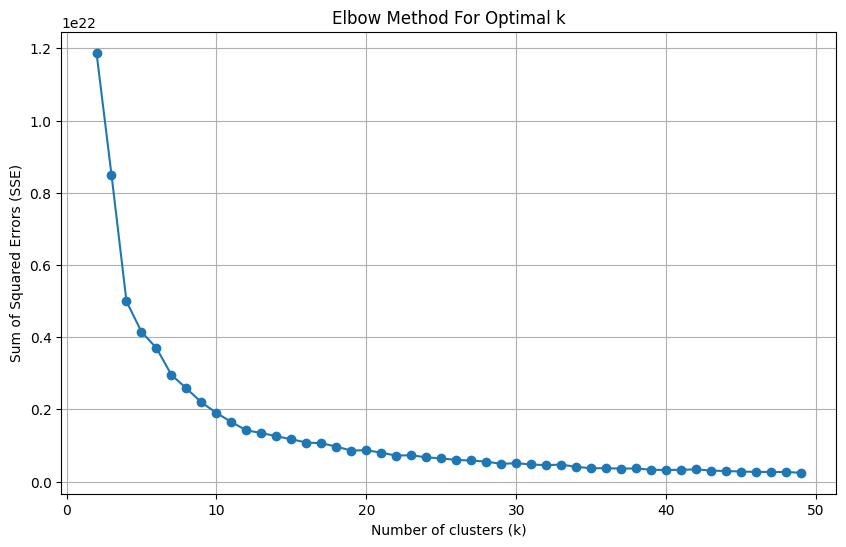

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=num_of_clusters, init='k-means++', random_state=42).fit(kmeans_data)
kmeans_labels = kmeans.labels_

pd.Series(kmeans_labels).value_counts()

1    1073
9    1002
2     981
8     911
5     675
4     669
0     616
6     611
3     558
7     394
Name: count, dtype: int64

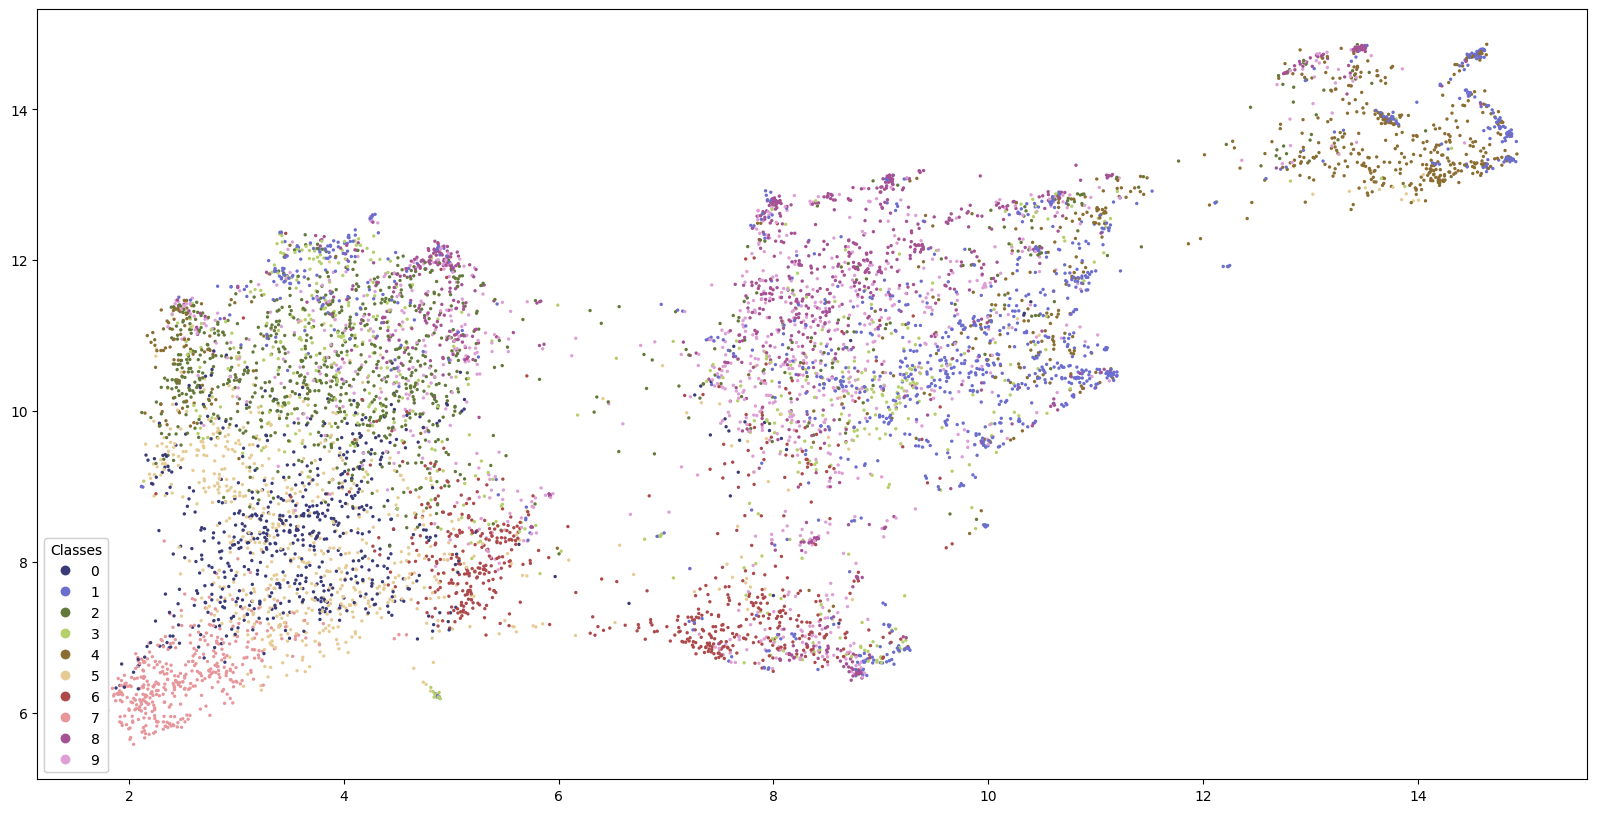

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(vc_embedding[:, 0], vc_embedding[:, 1], s=2, c=kmeans_labels, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=num_of_clusters), loc="lower left", title="Classes")
ax.add_artist(legend1)

## Compare Clustering Methods Results
Evaluate the performance of different clustering algorithms using metrics and visualizations.

In [ ]:
#Setting the objects to category 
lgbm_data = vc_full_data.copy()

for c in categorical_data.columns:
    lgbm_data[c] = lgbm_data[c].astype('category')

lgbm_data

,Agriculture and Farming,Commerce and Shopping,Community and Lifestyle,Consumer Goods,Education,Events,Food and Beverage,Gaming,Government and Military,Information Technology,...,series_h,equity_crowdfunding,non_equity_assistance,initial_coin_offering,product_crowdfunding,series_i,series_j,mean_inv,selectivity_gini,avg_time_a_to_b
1,0,1,1,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1.297563e+08,0.352941,1.666163
2,0,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,3.414510e+07,0.150000,4.000000
5,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1.103084e+07,0.250000,1.500000
6,0,1,1,0,1,0,1,0,1,1,...,0,0,0,0,0,0,0,3.506410e+07,0.266667,1.779370
7,0,0,1,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,1.094215e+07,0.329545,1.273684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9614,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,5.999454e+07,0.000000,3.000000
9615,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4.640000e+07,0.133333,1.555556
9616,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5.307064e+07,0.000000,1.000000
9617,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5.759500e+07,0.000000,1.863636


### KModes

In [ ]:
clf_km = LGBMClassifier(colsample_by_tree=0.8).fit(lgbm_data, kmodes_labels)

shap_values_km = shap.TreeExplainer(clf_km).shap_values(lgbm_data)

shap.summary_plot(shap_values_km, lgbm_data, plot_type="bar", plot_size=(15, 10))

[LightGBM] [Warning] Unknown parameter: colsample_by_tree


LightGBMError: Length of labels differs from the length of #data

In [ ]:
cv_scores_km = cross_val_score(clf_km, lgbm_data, kmodes_labels, scoring='f1_weighted')
print(f'CV F1 score for K-Modes clusters is {np.mean(cv_scores_km)}')

### KPrototypes

In [ ]:
clf_kp = LGBMClassifier(colsample_by_tree=0.8).fit(lgbm_data, kproto_labels)

shap_values_kp = shap.TreeExplainer(clf_kp).shap_values(lgbm_data)

shap.summary_plot(shap_values_kp, lgbm_data, plot_type="bar", plot_size=(15, 10))

[LightGBM] [Warning] Unknown parameter: colsample_by_tree


LightGBMError: Do not support special JSON characters in feature name.

In [ ]:
cv_scores_kp = cross_val_score(clf_kp, lgbm_data, kproto_labels, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

### Kmeans

In [ ]:
clf_kp = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_kp = cross_val_score(clf_kp, lgbm_data, kmeans_labels, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 5992, number of used features: 77
[LightGBM] [Info] Start training from score -1,906959
[LightGBM] [Info] Start training from score -2,307940
[LightGBM] [Info] Start training from score -2,848856
[LightGBM] [Info] Start training from score -2,242982
[LightGBM] [Info] Start training from score -2,831712
[LightGBM] [Info] Start training from score -2,101035
[LightGBM] [Info] Start training from score -2,547578
[LightGBM] [Info] Start training from score -2,155709
[LightGBM] [Info] Start training from score -2,147100
[LightGBM] [Info] Start traini

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,001443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 7490, number of used features: 78
[LightGBM] [Info] Start training from score -1,906510
[LightGBM] [Info] Start training from score -2,306598
[LightGBM] [Info] Start training from score -2,850586
[LightGBM] [Info] Start training from score -2,242982
[LightGBM] [Info] Start training from score -2,832279
[LightGBM] [Info] Start training from score -2,101308
[LightGBM] [Info] Start training from score -2,548004
[LightGBM] [Info] Start training from score -2,156285
[LightGBM] [Info] St

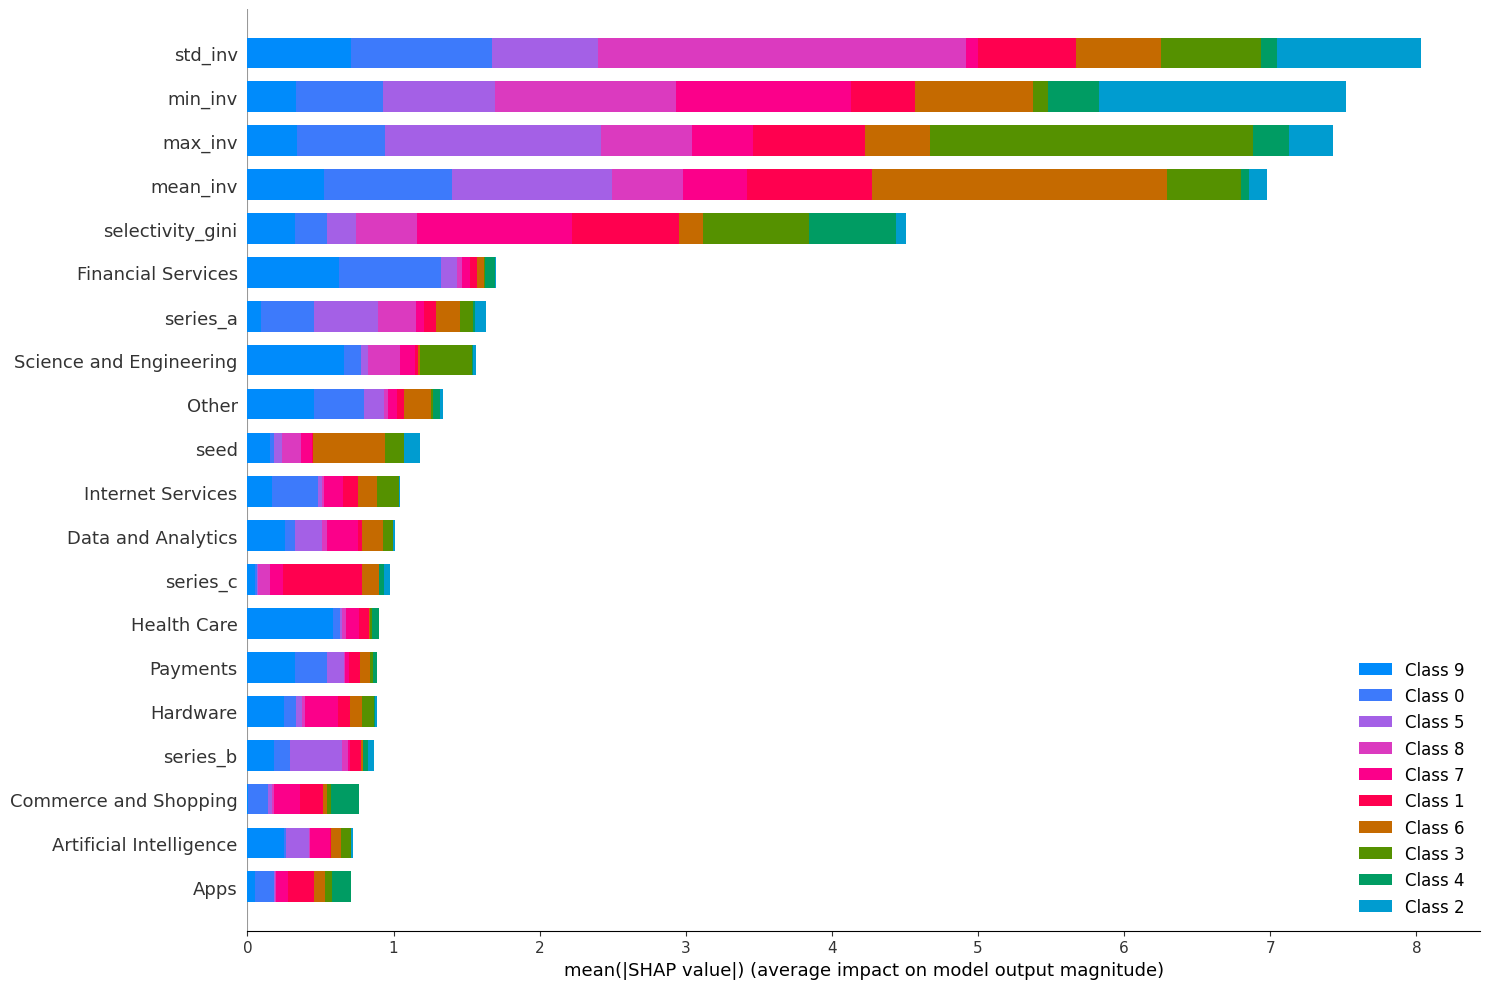

In [ ]:
clf_kp.fit(lgbm_data, kmeans_labels)
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(lgbm_data)
shap.summary_plot(shap_values_kp, lgbm_data, plot_type="bar", plot_size=(15, 10))

In [ ]:
""" # Elbow plot with cost (will take a LONG time)
costs = []
n_clusters = []
clusters_assigned = []

for i in tqdm(range(2, 25)):
    try:
        kproto = KPrototypes(n_clusters= i, init='Cao', verbose=2)
        # clusters = kproto.fit_predict(kprot_data, categorical=[0, 6, 7, 9, 13])
        clusters = kproto.fit_predict(kprot_data, categorical=categorical_columns)
        costs.append(kproto.cost_)
        n_clusters.append(i)
        clusters_assigned.append(clusters)
    except:
        print(f"Can't cluster with {i} clusters")
        
fig = plt.figure()
plt.plot(n_clusters, costs)
fig.show() 

fig = plt.figure()
plt.plot(n_clusters, costs)
fig.show()"""

' # Elbow plot with cost (will take a LONG time)\ncosts = []\nn_clusters = []\nclusters_assigned = []\n\nfor i in tqdm(range(2, 25)):\n    try:\n        kproto = KPrototypes(n_clusters= i, init=\'Cao\', verbose=2)\n        # clusters = kproto.fit_predict(kprot_data, categorical=[0, 6, 7, 9, 13])\n        clusters = kproto.fit_predict(kprot_data, categorical=categorical_columns)\n        costs.append(kproto.cost_)\n        n_clusters.append(i)\n        clusters_assigned.append(clusters)\n    except:\n        print(f"Can\'t cluster with {i} clusters")\n        \nfig = plt.figure()\nplt.plot(n_clusters, costs)\nfig.show() \n\nfig = plt.figure()\nplt.plot(n_clusters, costs)\nfig.show()'


medium value invested
-> we are dealing with restricted number of VCs, only the ones dealing with incubators

https://antonsruberts.github.io/kproto-audience/
https://stackoverflow.com/questions/2960864/how-to-save-all-the-variables-in-the-current-python-session